In [1]:
import numpy as np
from waveletFunctions import wavelet, wave_signif, wave_bases
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.ticker import StrMethodFormatter, NullFormatter

In [2]:
import sys

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
def recon_preprocess(var, time, anom_start, anom_end): 
    # Find indices to take anomalies over: 
    anom_ind = np.where((time<anom_end)&(time>=anom_start))
    
    var_2d = np.reshape(var,(var.shape[0],var.shape[1]*var.shape[2]))
    var_anom_2d = var_2d - np.nanmean(np.squeeze(var_2d[anom_ind,:]),axis=0)
    var_anom_mn = np.nanmean(var_anom_2d,axis=1)

    var_97_5 = np.percentile(var_anom_2d,97.5,axis=1)
    var_2_5 = np.percentile(var_anom_2d,2.5,axis=1)
    
    return var_2d, var_anom_2d, var_anom_mn , var_97_5, var_2_5

In [4]:
def plot_cwt(fig, ax, time, period, power, sig95, coi, title, levels, cmap='GnBu'):
    cmap = plt.cm.get_cmap(cmap)
    
    ls = [n/(len(levels)-2) for n in range(len(levels))]

    CS = ax.contourf(time, period, power, levels, 
                     colors = [cmap(n) for n in ls])  #*** or use 'contour'

    #ax.set_xlabel('Time (year)', fontsize=14)
    ax.set_ylabel('Period (years)', fontsize=14)
    ax.set_title(title, fontsize=16, loc='right')
    ax.set_xlim([time.min(),time.max()])

    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    ax.contour(time, period, sig95, [-99, 1], colors='k')

    # cone-of-influence, anything "below" is dubious
    ax.plot(time, coi, 'k')
    ax.fill_between(time,coi,y2=period.max(),color='k', alpha=0.5)

    # format y-scale
    ax.set_yscale('log', basey=2, subsy=None) #
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_minor_formatter(NullFormatter())
#     ax_x = plt.gca().yaxis
#     ax.set_major_formatter(ticker.ScalarFormatter())
#    ax.ticklabel_format(axis='y', style='plain') #

    ax.set_ylim([period.min(), 500])
    ax.invert_yaxis()
    
    return CS

In [5]:
def get_cwt(data,time,dt,pad,dj,s0,j1,mother,lag1,param=-1):
    n = len(data)
    
    variance = np.std(data, ddof=1) ** 2
    
    # Wavelet transform:
    wave, period, scale, coi = wavelet(data, dt, pad, dj, s0, j1, mother, param=param)
    power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
    global_ws = (np.sum(power, axis=1) / n)  # time-average over all times
    
    # Significance levels:
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
    sig95 = power / sig95  # where ratio > 1, power is significant
    
    return period, power, sig95, coi, time

In [6]:
def calc_lac(fcast, obs):
    """
    Method to calculate the Local Anomaly Correlation (LAC).  Uses numexpr
    for speed over larger datasets.

    Note: If necessary (memory concerns) in the future, the numexpr statements
    can be extended to use pytable arrays.  Would need to provide means to
    function, as summing over the dataset is still very slow it seems.

    Parameters
    ----------
    fcast: ndarray
        Time series of forecast data. M x N where M is the temporal dimension.
    obs: ndarray
        Time series of observations. M x N

    Returns
    -------
    lac: ndarray
        Local anomaly corellations for all locations over the time range.
    """
    # Calculate means of data
    f_mean = fcast.mean(axis=0)
    o_mean = obs.mean(axis=0)
    f_anom = fcast - f_mean
    o_anom = obs - o_mean
    
    # Calculate covariance between time series at each gridpoint
    cov = (f_anom * o_anom).sum(axis=0)

    # Calculate standardization terms
    f_std = (f_anom**2).sum(axis=0)
    o_std = (o_anom**2).sum(axis=0)
#     if is_dask_array(f_std):
#         f_std = da.sqrt(f_std)
#     else:
#         f_std = np.sqrt(f_std)

#     if is_dask_array(o_std):
#         o_std = da.sqrt(o_std)
#     else:
#         o_std = np.sqrt(o_std)
    f_std = np.sqrt(f_std)
    o_std = np.sqrt(o_std)
    
    std = f_std * o_std
    lac = cov / std

    return lac

In [7]:
import xarray as xr 

## Load volcanic forcing data: 

In [8]:
volc_dir = '/home/disk/enkf2/lakp/Data/CESM_LME/Forcings/'
volc_filename = 'IVI2LoadingLatHeight501-2000_L18_c20100518.nc'

volc_ds = xr.open_dataset(volc_dir+volc_filename)

In [128]:
volc_ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 18, time: 18002)
Coordinates:
  * time     (time) float32 500.95834 501.0417 501.125 ... 2000.9584 2001.0416
  * lev      (lev) float32 4.8093 13.073097 32.5591 ... 929.276 970.4459 992.528
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
Data variables:
    MMRVOLC  (time, lev, lat) float64 ...
    colmass  (time, lat) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    datesec  (time) float64 ...
    date     (time) float64 ...
Attributes:
    title:          IVI2LoadingLatHeight501-2000.bin converted to 18 pressure...
    reference:      Gao,Robock,and Ammann,2008:J. Geophys. Res,doi:10.1029/20...
    created_by:     hteng: copper.cgd.ucar.edu:/datalocal/ccpa/hteng/volcano/...
    creation_date:   2010-05-18
    modification:   Z2P is based on ccsm4.p2z.nc, derived from b40.1850.track...

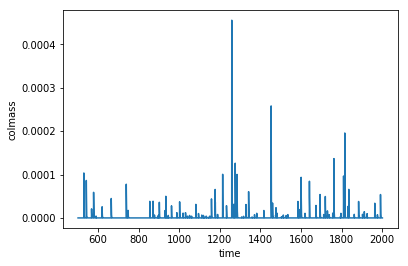

In [13]:
volc_ds.colmass.mean('lat').plot()

In [56]:
volc_colmass_gm = volc_ds.colmass.mean('lat').values
volc_colmass_gman = np.nanmean(np.reshape(volc_colmass_gm[1:-1], (1500,12)),axis=1)
volc_colmass_gman_sum = np.sum(np.reshape(volc_colmass_gm[1:-1], (1500,12)),axis=1)
volc_time = np.arange(501,2001,1)

(0, 0.0025)

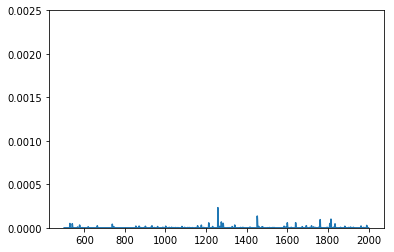

In [59]:
plt.plot(volc_time,volc_colmass_gman)
#plt.plot(volc_time,volc_colmass_gman_sum)
plt.ylim(0,0.0025)

In [355]:
import pandas as pd 
volc_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Sigl2015/'
#volc_filename = '41586_2015_BFnature14565_MOESM37_ESM.xlsx'
volc_filename = 'sigl_etal_2015_fig3_data.csv'

#df = pd.read_excel(volc_dir+volc_filename)
df = pd.read_csv(volc_dir+volc_filename)

In [192]:
global_forcing_TP = df['Global forcing (tropical)'][1:81].values
global_forcing_TPtime = df['Start Year .1'][1:81].values
global_forcing_SH = df['Global forcing (SH)'][1:62].values
global_forcing_SHtime = df['Start Year .3'][1:62].values
global_forcing_NH = df['Global forcing (NH)'][1:].values
global_forcing_NHtime = df['Start Year .2'][1:].values

In [193]:
for i in range(global_forcing_TP.shape[0]):
    global_forcing_TP[i] = float(global_forcing_TP[i])
    global_forcing_TPtime[i] = int(global_forcing_TPtime[i])

for i in range(global_forcing_NH.shape[0]):
    global_forcing_NH[i] = float(global_forcing_NH[i])
    global_forcing_NHtime[i] = int(global_forcing_NHtime[i])
    
for i in range(global_forcing_SH.shape[0]):
    global_forcing_SH[i] = float(global_forcing_SH[i])
    global_forcing_SHtime[i] = int(global_forcing_SHtime[i])

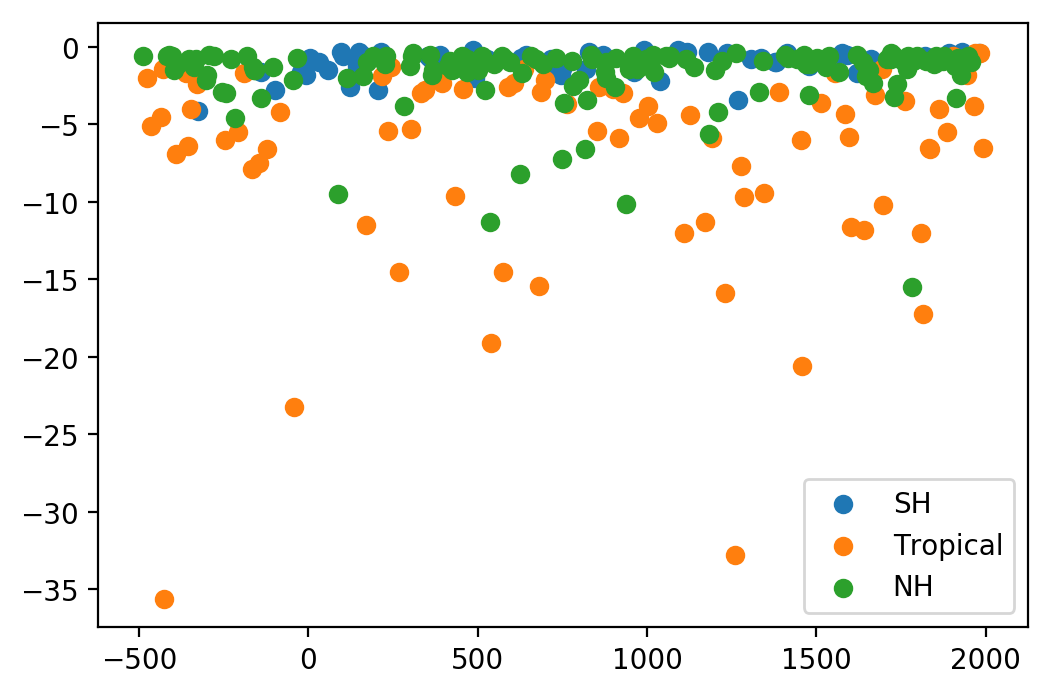

In [198]:
plt.scatter(global_forcing_SHtime,global_forcing_SH, label='SH')
plt.scatter(global_forcing_TPtime,global_forcing_TP, label = 'Tropical')
plt.scatter(global_forcing_NHtime,global_forcing_NH, label='NH')

plt.legend()
#plt.xticks(np.arange(-500,1995,100))
#plt.yticks(np.arange(-16,0,1))

In [377]:
global_forcing_NH_full = np.zeros(1871)
vals = global_forcing_NH[0:-25]
val_times = global_forcing_NHtime[0:-25]
volc_time_full = np.arange(87,1958,1)
n=val_times.shape[0] -1

for t in range(1871):
#    print(str(time_full[t])+', '+str(val_times[n]))
    if volc_time_full[t] == val_times[n]:
#        print(str(val_times[n])+', '+str(vals[n]))
        global_forcing_NH_full[t]=vals[n]
        n = n-1
    else: 
        global_forcing_NH_full[i]=0

In [365]:
global_forcing_TPtime[0:-18]

array([1992, 1982, 1968, 1964, 1943, 1903, 1884, 1862, 1836, 1832, 1815,
       1809, 1762, 1695, 1693, 1673, 1641, 1601, 1595, 1585, 1554, 1512,
       1458, 1453, 1389, 1345, 1286, 1276, 1258, 1230, 1191, 1171, 1127,
       1108, 1028, 1003, 976, 929, 916, 900, 859, 853, 764, 698, 688, 682,
       637, 607, 589, 574, 540, 456, 433, 393, 345, 332, 304, 266, 244,
       236, 218, 169], dtype=object)

In [385]:
global_forcing_TPtime[0:-18].shape, global_forcing_NHtime[0:-25].shape

((62,), (115,))

In [376]:
global_forcing_TP_full = np.zeros(volc_time_full.shape[0])
vals = global_forcing_TP[0:-18]
val_times = global_forcing_TPtime[0:-18]
volc_time_full_TP = np.arange(169,1993,1)
n=val_times.shape[0]-1

for t in range(volc_time_full.shape[0]):
#    print(str(time_full[t])+', '+str(val_times[n]))
    if volc_time_full[t] == val_times[n]:
#        print(str(val_times[n])+', '+str(vals[n]))
        global_forcing_TP_full[t]=vals[n]
        n = n-1
    else: 
        global_forcing_TP_full[i]=0

In [374]:
 global_forcing_TP_full.sum(), global_forcing_TP[0:-18].sum()

(-418.09999999999997, -418.09999999999997)

In [334]:
window = 20
lengtht = global_forcing_NH_full.shape[0]-window
global_forcing_NH_rnmn = np.zeros(lengtht)

for t in range(lengtht):
    global_forcing_NH_rnmn[t] = global_forcing_NH_full[t:t+window].mean()

In [335]:
global_forcing_NH_full

array([-9.5,  0. ,  0. , ...,  0. ,  0. , -1. ])

In [336]:
Wn2 = 1.0/5
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
global_forcing_TP_filt = signal.filtfilt(b2,a2,global_forcing_TP)
global_forcing_SH_filt = signal.filtfilt(b2,a2,global_forcing_SH)
global_forcing_NH_filt = signal.filtfilt(b2,a2,global_forcing_NH_full)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [381]:
global_forcing_TP_full.min()

-32.8

(0, -35)

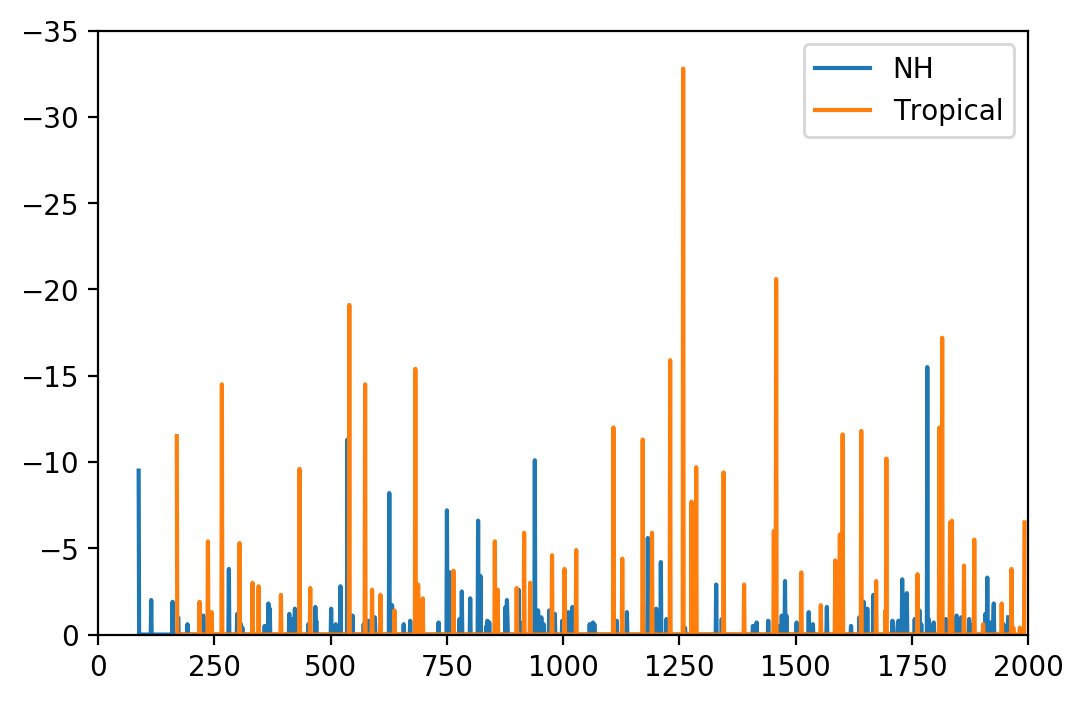

In [382]:
# plt.plot(global_forcing_SHtime,global_forcing_SH_filt, label='SH')
# plt.plot(global_forcing_TPtime,global_forcing_TP_filt, label = 'Tropical')
# plt.plot(np.arange(87,87+lengtht,1),global_forcing_NH_rnmn, label='NH')
# plt.plot(time_full,global_forcing_NH_filt, label='NH')
# plt.scatter(global_forcing_NHtime,global_forcing_NH, label='NH')
plt.plot(volc_time_full,global_forcing_NH_full, label='NH')
plt.plot(volc_time_full_TP,global_forcing_TP_full, label='Tropical')

plt.legend()

plt.xlim(0,2000)
plt.ylim(0,-35)

## Load reconstructed sea ice data: 

In [8]:
output_dir_full = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_full = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_full, tas_lalo_allit_full, sic_ens_var_allit_full, 
 nobs_allit_full, sia_ens_allit_full, sie_ens_allit_full, Ye_assim_allit_full, 
 Ye_assim_coords_allit_full, Xb_inflate_allit_full, recon_years_full, 
 proxy_assim_loc_allit_full] = ce_utils.load_recon_allit(output_dir_full,output_file_full,niter)

In [80]:
output_dir_f770 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_f770 = 'sic_ccsm4_anrecon_fixedprox_1200_1970_fixedprox_inf2_6_loc15000_iter0.pkl'

niter = 1

[sic_lalo_allit_f770, tas_lalo_allit_f770, sic_ens_var_allit_f770, 
 nobs_allit_f770, sia_ens_allit_f770, sie_ens_allit_f770, Ye_assim_allit_f770, 
 Ye_assim_coords_allit_f770, Xb_inflate_allit_f770, recon_years_f770, 
 proxy_assim_loc_allit_f770] = ce_utils.load_recon_allit(output_dir_f770,output_file_f770,niter)

In [81]:
output_dir_f400 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_f400 = 'sic_ccsm4_anrecon_fixedprox_1600_2000_fixedprox_inf2_6_loc15000_iter0.pkl'

niter = 1

[sic_lalo_allit_f400, tas_lalo_allit_f400, sic_ens_var_allit_f400, 
 nobs_allit_f400, sia_ens_allit_f400, sie_ens_allit_f400, Ye_assim_allit_f400, 
 Ye_assim_coords_allit_f400, Xb_inflate_allit_f400, recon_years_f400, 
 proxy_assim_loc_allit_f400] = ce_utils.load_recon_allit(output_dir_f400,output_file_f400,niter)

In [82]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, fet_sie_anom, fet_time] = rrutils.load_annual_satellite_anom(1980)
[fet_sia, fet_sie, fet_time2] = rrutils.load_annual_satellite()

In [10]:
anom_start = 1900
anom_end = 1940

[sie_ens_allit_2d_f770, 
 sie_ens_anom_allit_f770, 
 sie_ensmn_anom_allit_f770, 
 sie_97_5_allit_f770, 
 sie_2_5_allit_f770] = recon_preprocess(sie_ens_allit_f770, np.array(recon_years_f770), anom_start, anom_end)

NameError: name 'sie_ens_allit_f770' is not defined

In [84]:
anom_start = 1900
anom_end = 1940

[sie_ens_allit_2d_f400, 
 sie_ens_anom_allit_f400, 
 sie_ensmn_anom_allit_f400, 
 sie_97_5_allit_f400, 
 sie_2_5_allit_f400] = recon_preprocess(sie_ens_allit_f400, np.array(recon_years_f400), anom_start, anom_end)

In [11]:
[sie_ens_allit_2d_full, 
 sie_ens_anom_allit_full, 
 sie_ensmn_anom_allit_full, 
 sie_97_5_allit_full, 
 sie_2_5_allit_full] = recon_preprocess(sie_ens_allit_full, np.array(recon_years_full), anom_start, anom_end)

In [86]:
[ce_full_f400,corr_full_f400,_,_] = rrutils.find_ce_corr(sie_ensmn_anom_allit_f400, 
                                                         sie_ensmn_anom_allit_full,
                                                         np.array(recon_years_full),
                                                         np.array(recon_years_f400),
                                                         1600,2000)
[ce_full_f770,corr_full_f770,_,_] = rrutils.find_ce_corr(sie_ensmn_anom_allit_f770, 
                                                         sie_ensmn_anom_allit_full,
                                                         np.array(recon_years_full),
                                                         np.array(recon_years_f770),
                                                         1200,1969)

In [87]:
ce_full_f400,corr_full_f400,ce_full_f770,corr_full_f770

(0.4478201681970706,
 0.7762323093677699,
 0.6002319629219564,
 0.8177149927989201)

In [88]:
plt.rcParams['figure.dpi']=200

In [89]:
from scipy import signal

Wn2 = 1.0/20
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
sie_full_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_full)
sie_f770_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_f770)
sie_f400_filt20 = signal.filtfilt(b2,a2,sie_ensmn_anom_allit_f400)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


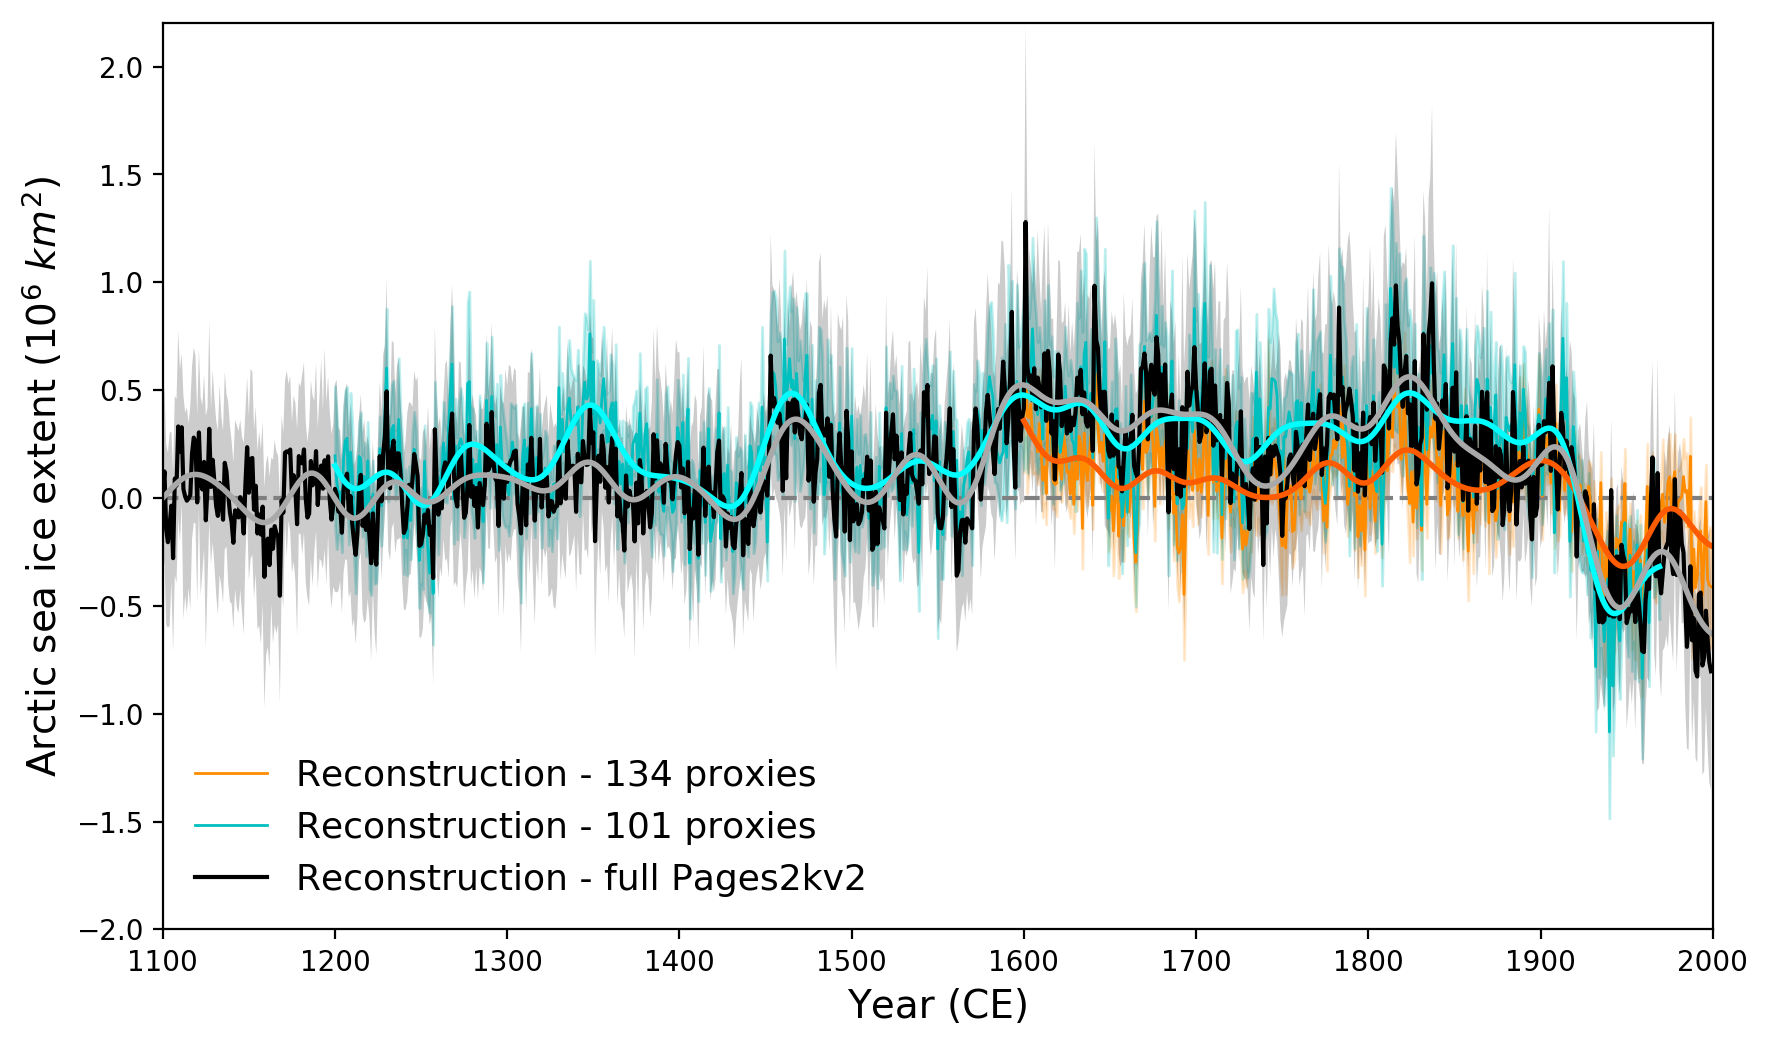

In [90]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')


# plt.fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
#                  color='k',alpha=0.2, linewidth=0.0)
plt.fill_between(recon_years_f400,sie_2_5_allit_f400,sie_97_5_allit_f400,
                 color='darkorange',alpha=0.2)
plt.fill_between(recon_years_f770,sie_2_5_allit_f770,sie_97_5_allit_f770,
                 color='c',alpha=0.25)
plt.fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
                 color='k',alpha=0.2, linewidth=0.0)

# plt.plot(mpi_time[it_mpi],sie_nh_mpi_anom, label='MPI LM',
#          color='gray',linewidth=1, linestyle ='--')
# plt.plot(recon_years_full,sie_ensmn_anom_allit_full, label='Recon - full',
#          color='k',linewidth=2)
plt.plot(recon_years_f400,sie_ensmn_anom_allit_f400, label = 'Reconstruction - 134 proxies',
         color='darkorange',linewidth=1.0)
plt.plot(recon_years_f770,sie_ensmn_anom_allit_f770, label = 'Reconstruction - 101 proxies',
         color='c',linewidth=1.0)
plt.plot(recon_years_full,sie_ensmn_anom_allit_full, label='Reconstruction - full Pages2kv2',
         color='k',linewidth=1.5)


plt.plot(recon_years_f400,sie_f400_filt20,color='#ff5b00',linewidth=2.0)
plt.plot(recon_years_f770,sie_f770_filt20,color='cyan',linewidth=2.0)
plt.plot(recon_years_full,sie_full_filt20,color='darkgray',linewidth=2)

plt.ylabel('Arctic sea ice extent (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='lower left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_full_f400 = (('(Full vs                    ):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_full_f400**2))+
                     ', CE = '+'{:,.2f}'.format(ce_full_f400))
ce_corr_full_f770 = (('(Full vs                    ):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_full_f770**2))+
                     ', CE = '+'{:,.2f}'.format(ce_full_f770))

# plt.text(1120,-1.5,ce_corr_full_f400,color='k',fontsize=14)
# plt.text(1120,-1.8,ce_corr_full_f770,color='k',fontsize=14)
# plt.text(1210,-1.8,'101 proxies',color='lightseagreen',fontsize=14)
# plt.text(1210,-1.5,'134 proxies',color='darkorange',fontsize=14)

plt.xlim(1100,2000)
plt.ylim(-2.0,2.2)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Fixed_proxy_full_timeseries_1100_2000.png'
#plt.savefig(savedir+savename)

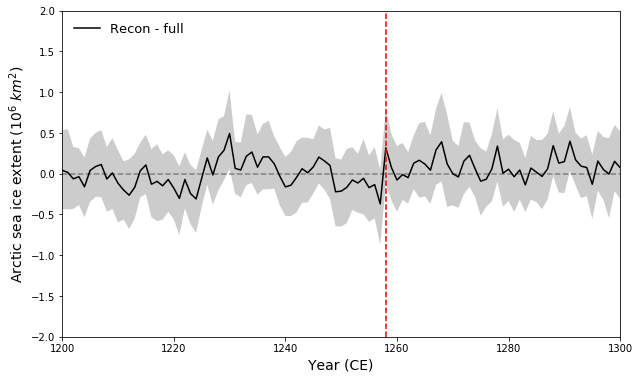

In [15]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

# plt.plot(recon_years_f400,sie_ensmn_anom_allit_f400, label = 'Recon - 134 proxies',
#          color='darkorange',linewidth=1.0)
# plt.plot(recon_years_f770,sie_ensmn_anom_allit_f770, label = 'Recon - 101 proxies',
#          color='lightseagreen',linewidth=1.0)
plt.plot(recon_years_full,sie_ensmn_anom_allit_full, label='Recon - full',
         color='k',linewidth=1.5)
# plt.plot(fet_time,fet_sie_anom, label='Satellite',color='crimson',linewidth=1.5)
# plt.plot(years_f400_append,sie_ensmn_anom_f400_sat_append, label='Recon - sat append',
#          color='firebrick',linewidth=1.5,linestyle='--')


# plt.fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
#                  color='k',alpha=0.2, linewidth=0.0)

# plt.fill_between(recon_years_f400,sie_2_5_allit_f400,sie_97_5_allit_f400,
#                  color='darkorange',alpha=0.2)
# plt.fill_between(recon_years_f770,sie_2_5_allit_f770,sie_97_5_allit_f770,
#                  color='lightseagreen',alpha=0.25)
plt.fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
                 color='k',alpha=0.2, linewidth=0.0)

plt.ylabel('Arctic sea ice extent (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
#plt.ylim(-3,4,1)
plt.ylim(-2,2,1)

plt.xlim(1200,1300)
plt.axvline(1258, color='r', linestyle='--')

#plt.ylim(-2,2.5)

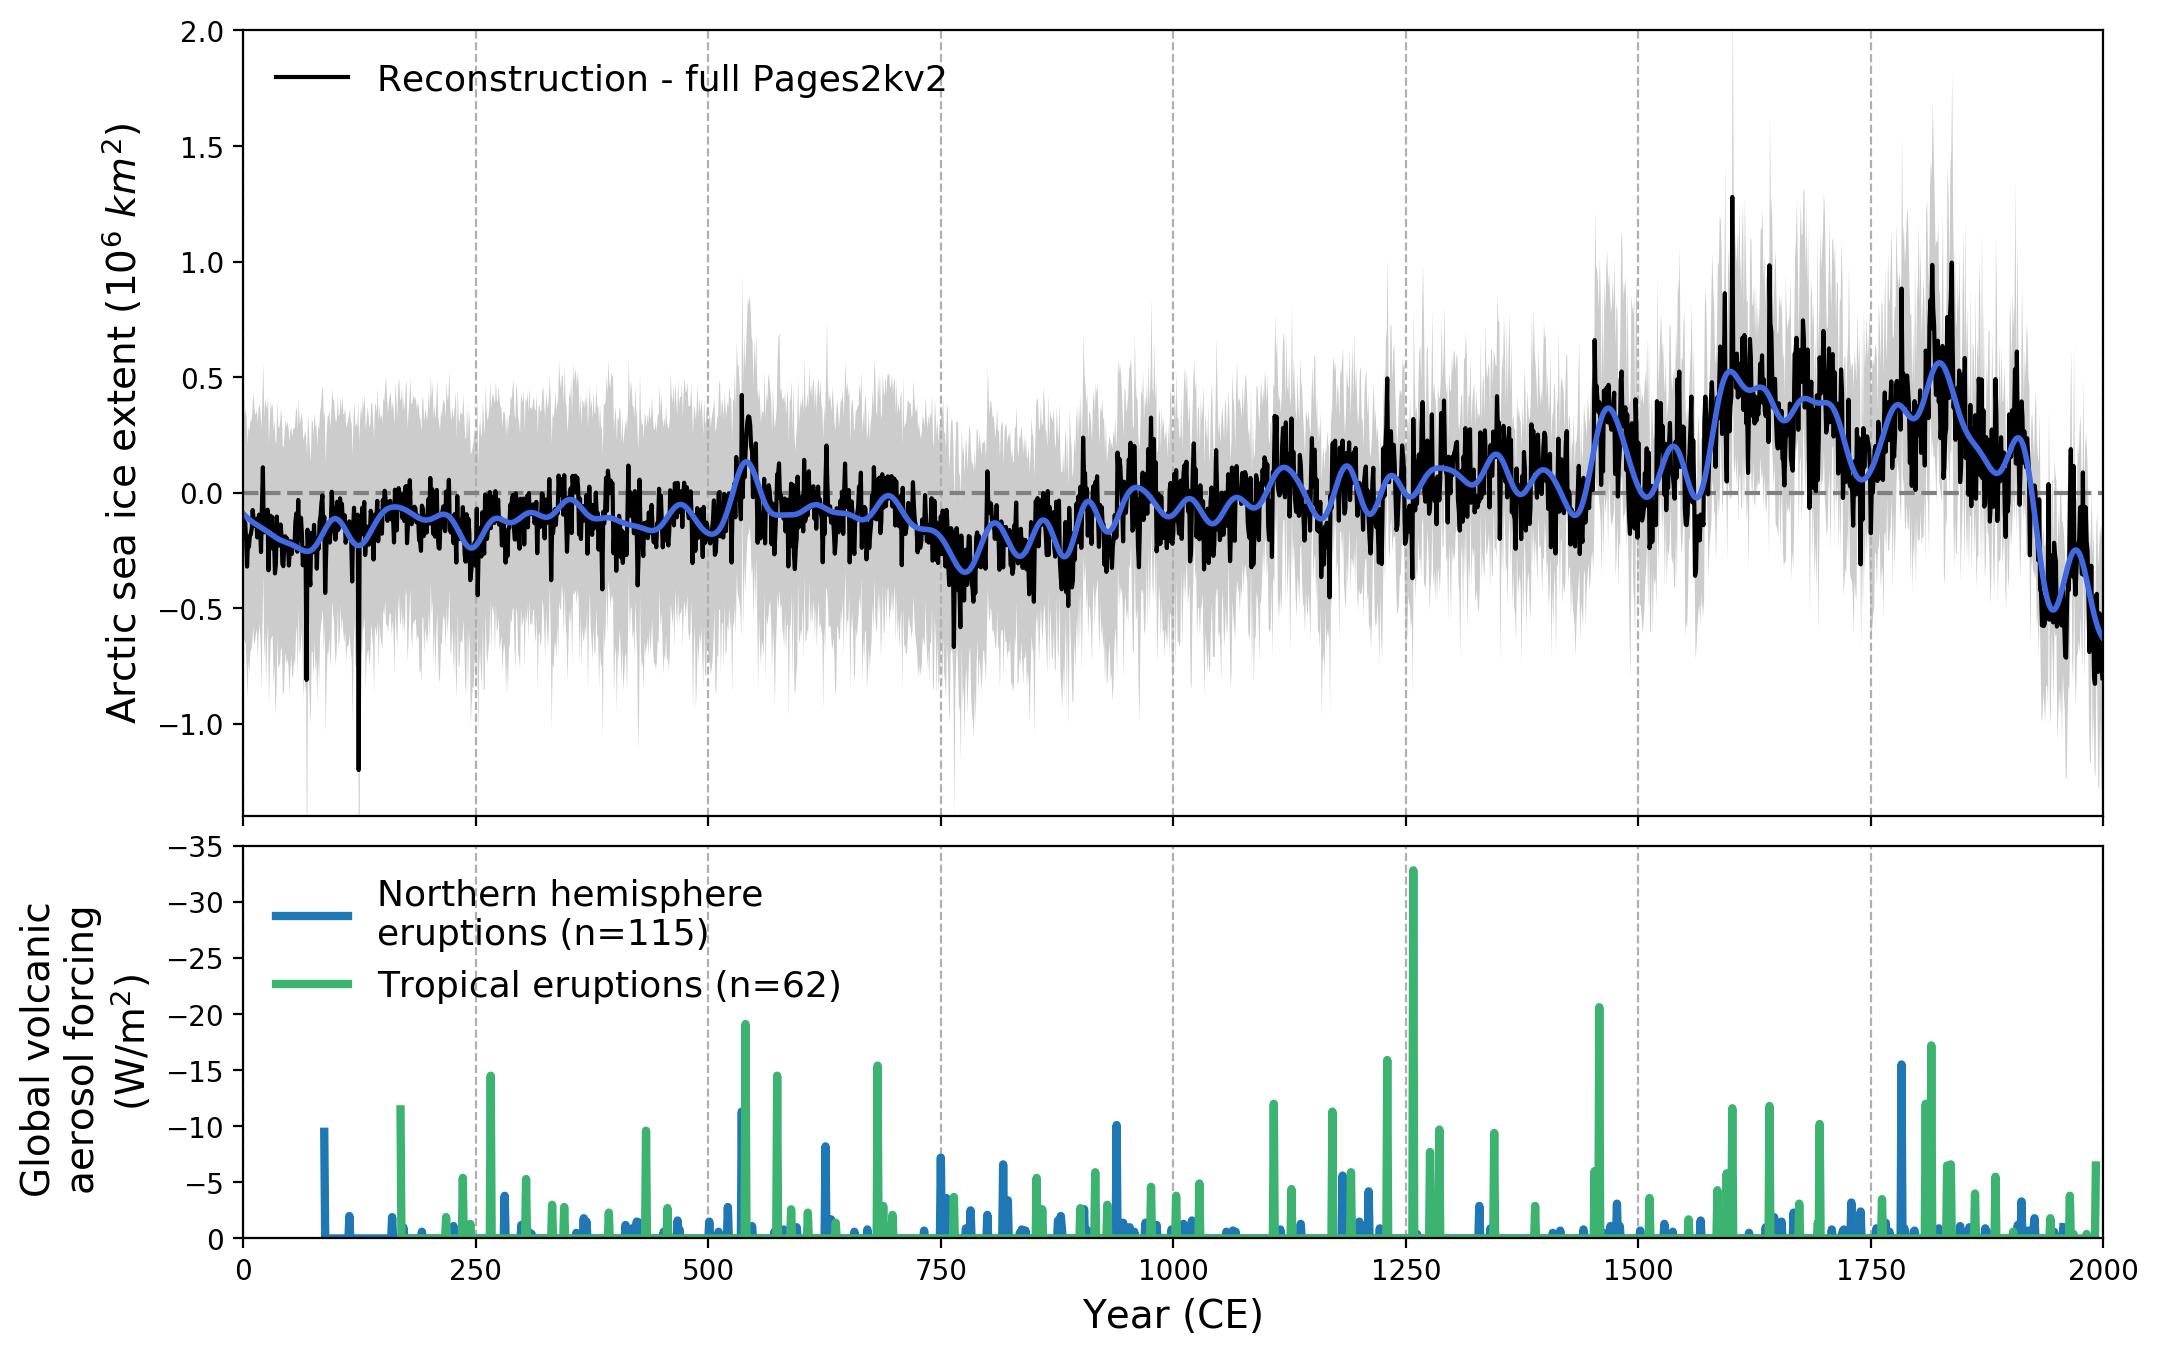

In [412]:
fig, ax = plt.subplots(2,1,figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [4,2]})
ax = ax.flatten()
ax[0].axhline(0,linestyle='--',color='grey')


ax[0].fill_between(recon_years_full,sie_2_5_allit_full,sie_97_5_allit_full,
                 color='k',alpha=0.2, linewidth=0.0)
ax[0].plot(recon_years_full,sie_ensmn_anom_allit_full, label='Reconstruction - full Pages2kv2',
         color='k',linewidth=1.5)

ax[0].plot(recon_years_full,sie_full_filt20,color='royalblue',linewidth=2)

ax[0].set_ylabel('Arctic sea ice extent (10$^{6}$ $km^2$)',fontsize=14)

ax[0].legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
ax[0].set_ylim(-1.4,2.)

ax[1].plot(volc_time_full,global_forcing_NH_full, 
           label='Northern hemisphere \neruptions (n=115)', linewidth=3)
ax[1].plot(volc_time_full_TP,global_forcing_TP_full, label='Tropical eruptions (n=62)', 
           color='mediumseagreen',linewidth=3)
ax[1].set_xlabel('Year (CE)',fontsize=14)
ax[1].legend(fontsize=13, loc='upper left', frameon=False)
ax[1].set_ylabel('Global volcanic \naerosol forcing \n(W/m$^2$)', fontsize=14)
#ax[1].spines['top'].set_visible(False)
ax[1].grid(linestyle='--',axis='x')
ax[0].grid(linestyle='--',axis='x')

ax[1].set_ylim(0,-35)

ax[0].set_xlim(0,2000)
ax[1].set_xlim(0,2000)

plt.subplots_adjust(wspace=0, hspace=0.05)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Recon_ccsm4_0_2000_volc_sigl.png'
#plt.savefig(savedir+savename)

In [92]:
sie_ensmn_anom_full_sat_append = np.zeros((2018))
sie_ensmn_anom_full_sat_append[0:1979] = sie_ensmn_anom_allit_full[0:1979]
sie_ensmn_anom_full_sat_append[1979:] = fet_sie_anom

years_append = np.arange(0,2018,1)

In [93]:
sie_ensmn_anom_f400_sat_append = np.zeros((418))
sie_ensmn_anom_f400_sat_append[0:379] = sie_ensmn_anom_allit_f400[0:379]
sie_ensmn_anom_f400_sat_append[379:] = fet_sie_anom

years_f400_append = np.arange(1600,2018,1)

In [150]:
1979-1600

379

In [131]:
dt = 1
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array

pad = 1  # pad the time series with zeroes (recommended)
dj =  0.125  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
#lag1 = 0.59  # lag-1 autocorrelation for red noise background
#print("lag1 = ", lag1)
mother = 'DOG'
#mother = 'PAUL'
#mother = 'MORLET'
p = 1

In [132]:
lag1_f400 = calc_lac(sie_ensmn_anom_allit_f400[:-1],sie_ensmn_anom_allit_f400[1:])
lag1_f770 = calc_lac(sie_ensmn_anom_allit_f770[:-1],sie_ensmn_anom_allit_f770[1:])
lag1_full = calc_lac(sie_ensmn_anom_allit_full[:-1],sie_ensmn_anom_allit_full[1:])
lag1_full_sat_append = calc_lac(sie_ensmn_anom_full_sat_append[:-1],sie_ensmn_anom_full_sat_append[1:])
lag1_f400_sat_append = calc_lac(sie_ensmn_anom_f400_sat_append[:-1],sie_ensmn_anom_f400_sat_append[1:])

lag1_full, lag1_f770, lag1_f400, lag1_full_sat_append, lag1_f400_sat_append

(0.760815356682638,
 0.6654263501655744,
 0.5909689898794328,
 0.8115307599608161,
 0.8726860598645688)

In [133]:
[period_f400, power_f400, 
 sig95_f400, coi_f400,
 time_f400] = get_cwt(sie_ensmn_anom_allit_f400,np.array(recon_years_f400),
                      dt,pad,dj,s0,j1,mother,lag1_f400,param=p)

[period_f770, power_f770, 
 sig95_f770, coi_f770,
 time_f770] = get_cwt(sie_ensmn_anom_allit_f770,np.array(recon_years_f770),
                      dt,pad,dj,s0,j1,mother,lag1_f770,param=p)

[period_full, power_full, 
 sig95_full, coi_full,
 time_full] = get_cwt(sie_ensmn_anom_allit_full,np.array(recon_years_full),
                      dt,pad,dj,s0,j1,mother,lag1_full,param=p)

[period_full_sat_append, power_full_sat_append, 
 sig95_full_sat_append, coi_full_sat_append,
 time_full_sat_append] = get_cwt(sie_ensmn_anom_full_sat_append,np.array(years_append),
                                 dt,pad,dj,s0,j1,mother,lag1_full_sat_append,param=p)

[period_f400_sat_append, power_f400_sat_append, 
 sig95_f400_sat_append, coi_f400_sat_append,
 time_f400_sat_append] = get_cwt(sie_ensmn_anom_f400_sat_append,np.array(years_f400_append),
                                 dt,pad,dj,s0,j1,mother,lag1_f400_sat_append,param=p)
    

In [134]:
period_f400.min(), nobs_allit_f400[0], nobs_allit_f770[0]

(10.260398641294913, array([134.]), array([101.]))

In [135]:
time_full[-1], time_f400[-1], time_f770[-1]

(1999, 1999, 1969)

In [338]:
time_full = np.arange(0,2000,1)

In [339]:
plt.rcParams['figure.dpi']=200

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


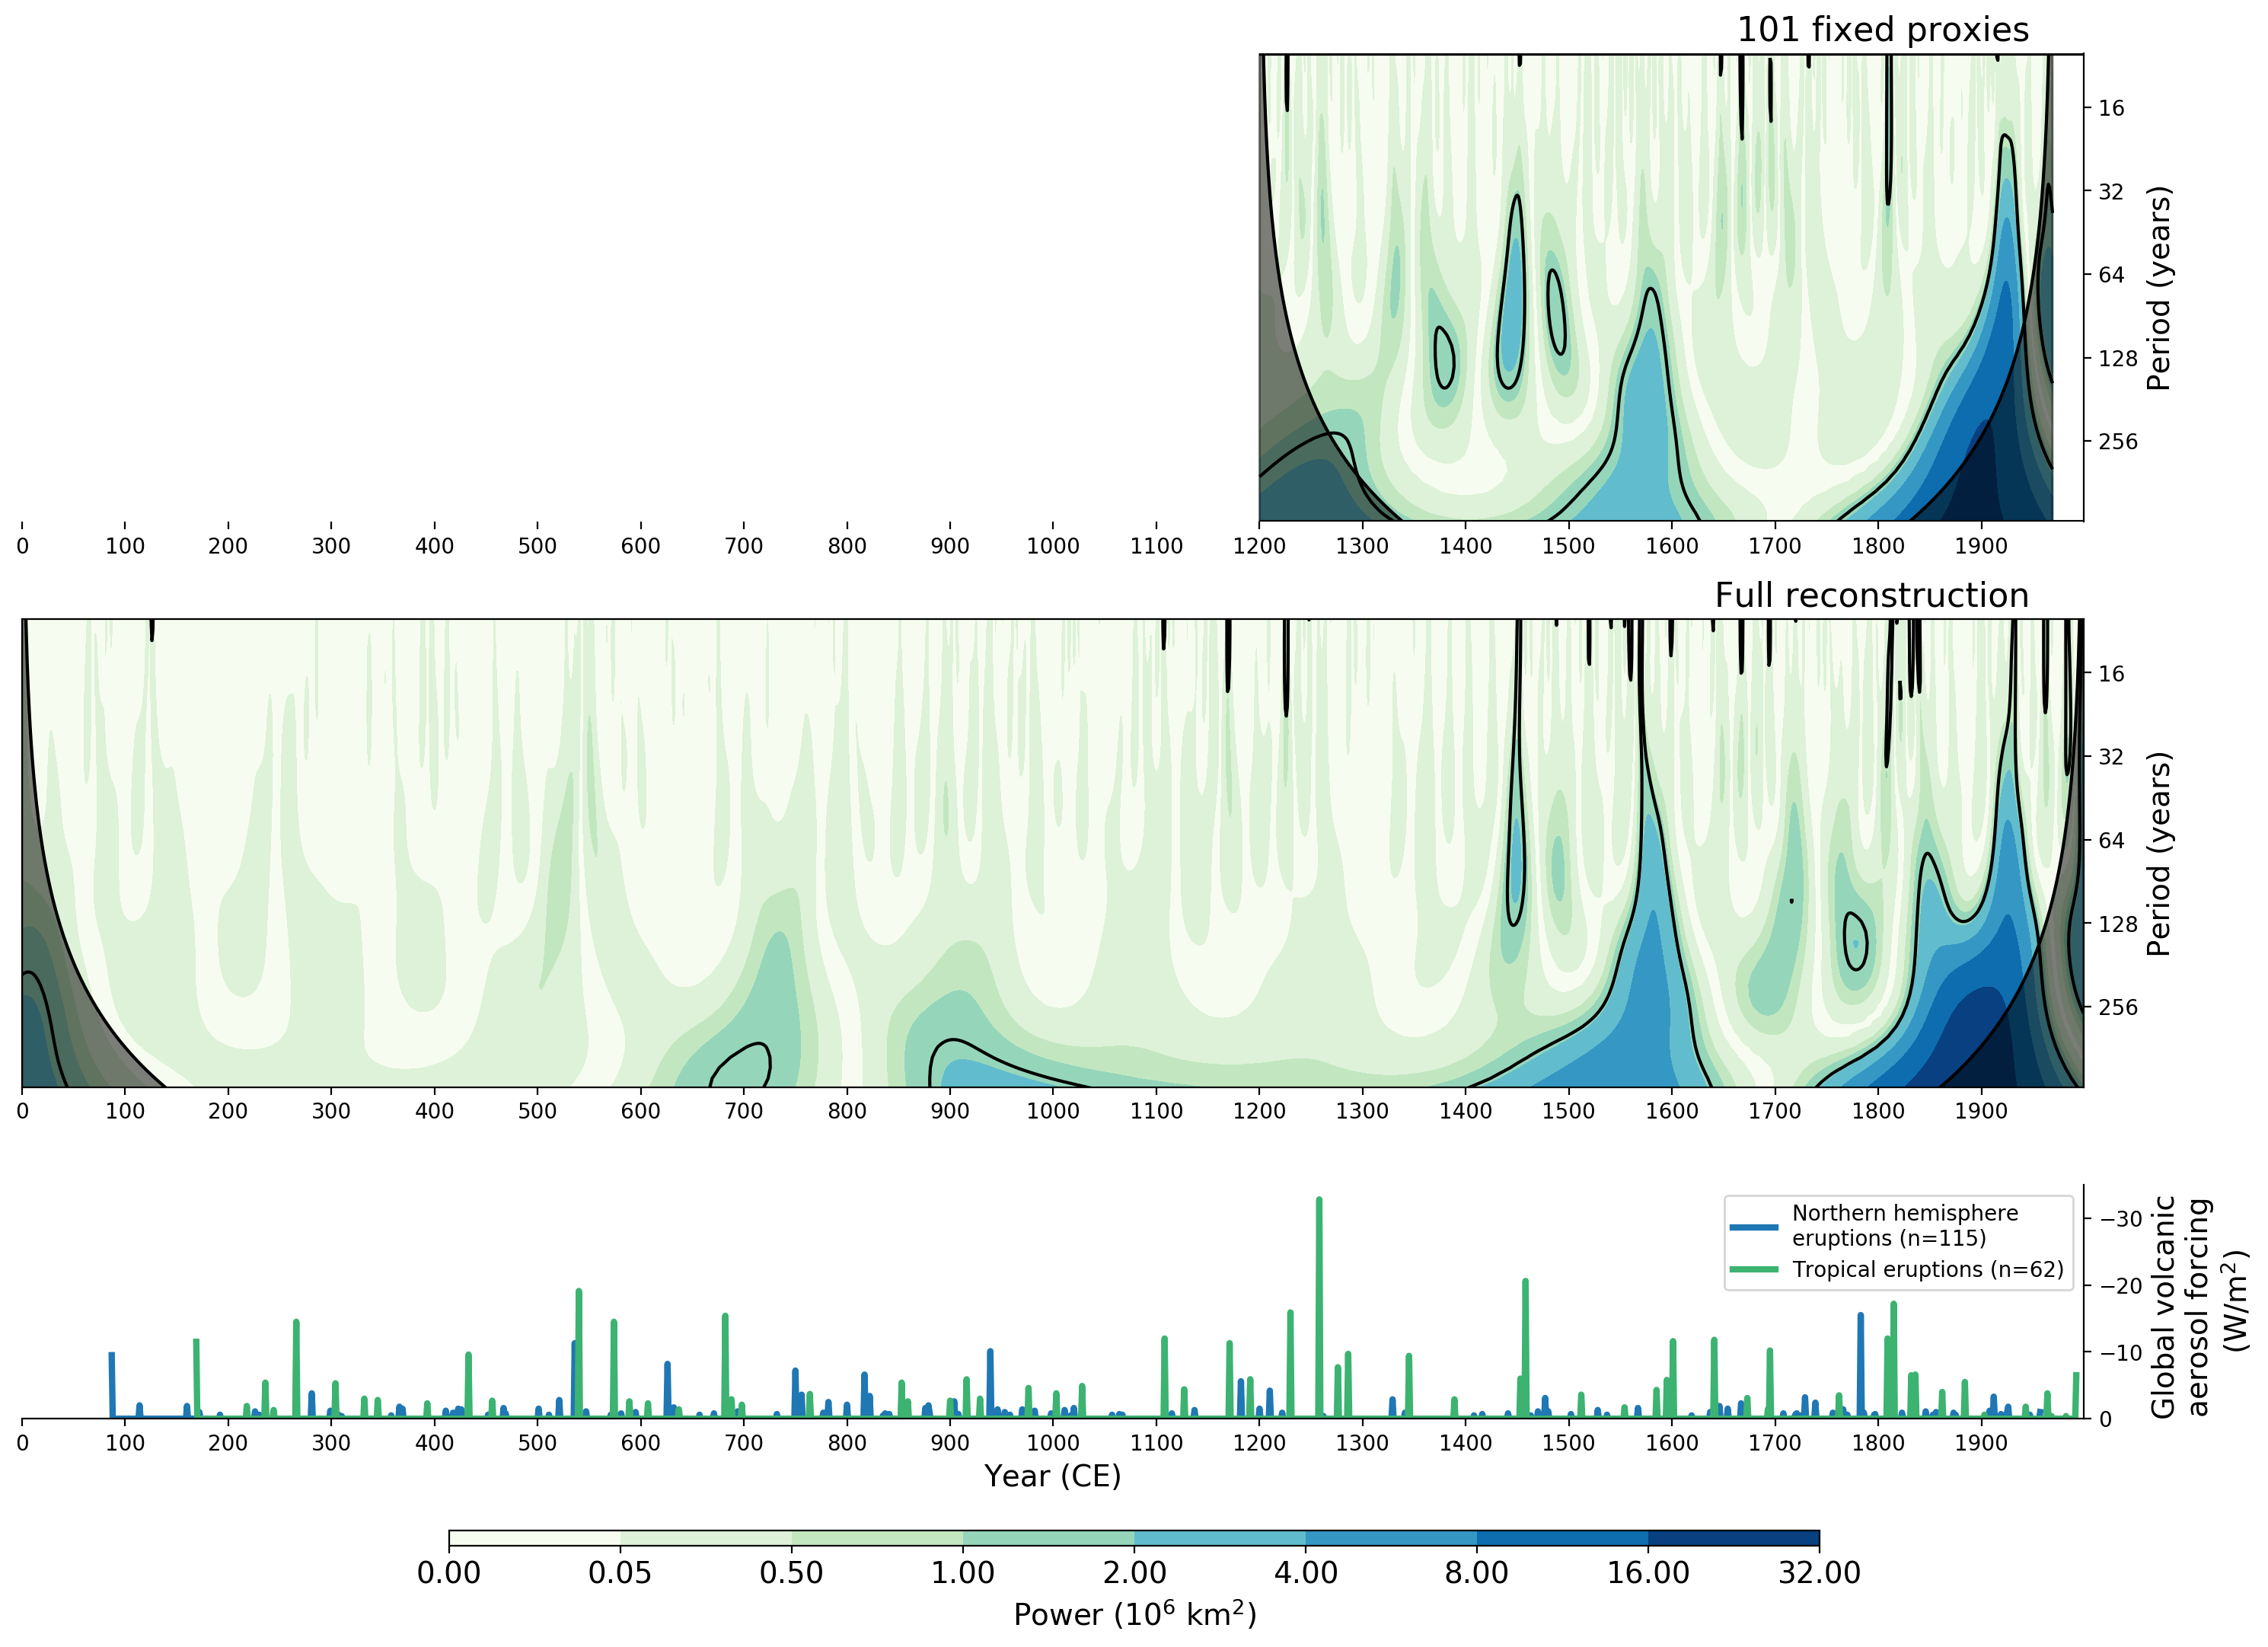

In [390]:
fig, ax = plt.subplots(3,1,figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [4,4,2]})
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32]
title_f400 = '134 fixed proxies     '
title_f770 = '101 fixed proxies     '
title_full = 'Full reconstruction     '

ax[0].set_xticks(np.arange(0,2001,100))
ax[1].set_xticks(np.arange(0,2001,100))
ax[2].set_xticks(np.arange(0,2001,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[0], time_f770, period_f770, power_f770, sig95_f770, coi_f770, title_f770, 
              levels=levels, cmap='GnBu')
im2 = plot_cwt(fig, ax[1], time_full, period_full, power_full, sig95_full, coi_full, title_full,
              levels=levels, cmap='GnBu')

ax[2].plot(volc_time_full,global_forcing_NH_full, 
           label='Northern hemisphere \neruptions (n=115)', linewidth=3)
ax[2].plot(volc_time_full_TP,global_forcing_TP_full, label='Tropical eruptions (n=62)', 
           color='mediumseagreen',linewidth=3)
ax[2].set_ylim(0,-35)
# ax[1].axhline(20)
# ax[1].axhline(70)

ax[2].set_xlabel('Year (CE)', fontsize=14)
ax[2].set_ylabel('Global volcanic \naerosol forcing \n(W/m$^2$)', fontsize=14)

ax[2].legend()

#ax[2].set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_visible(False)

ax[0].hlines(10.3,1200,2000,color='k')
ax[0].hlines(500,1200,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.015)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG1_f770_full_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


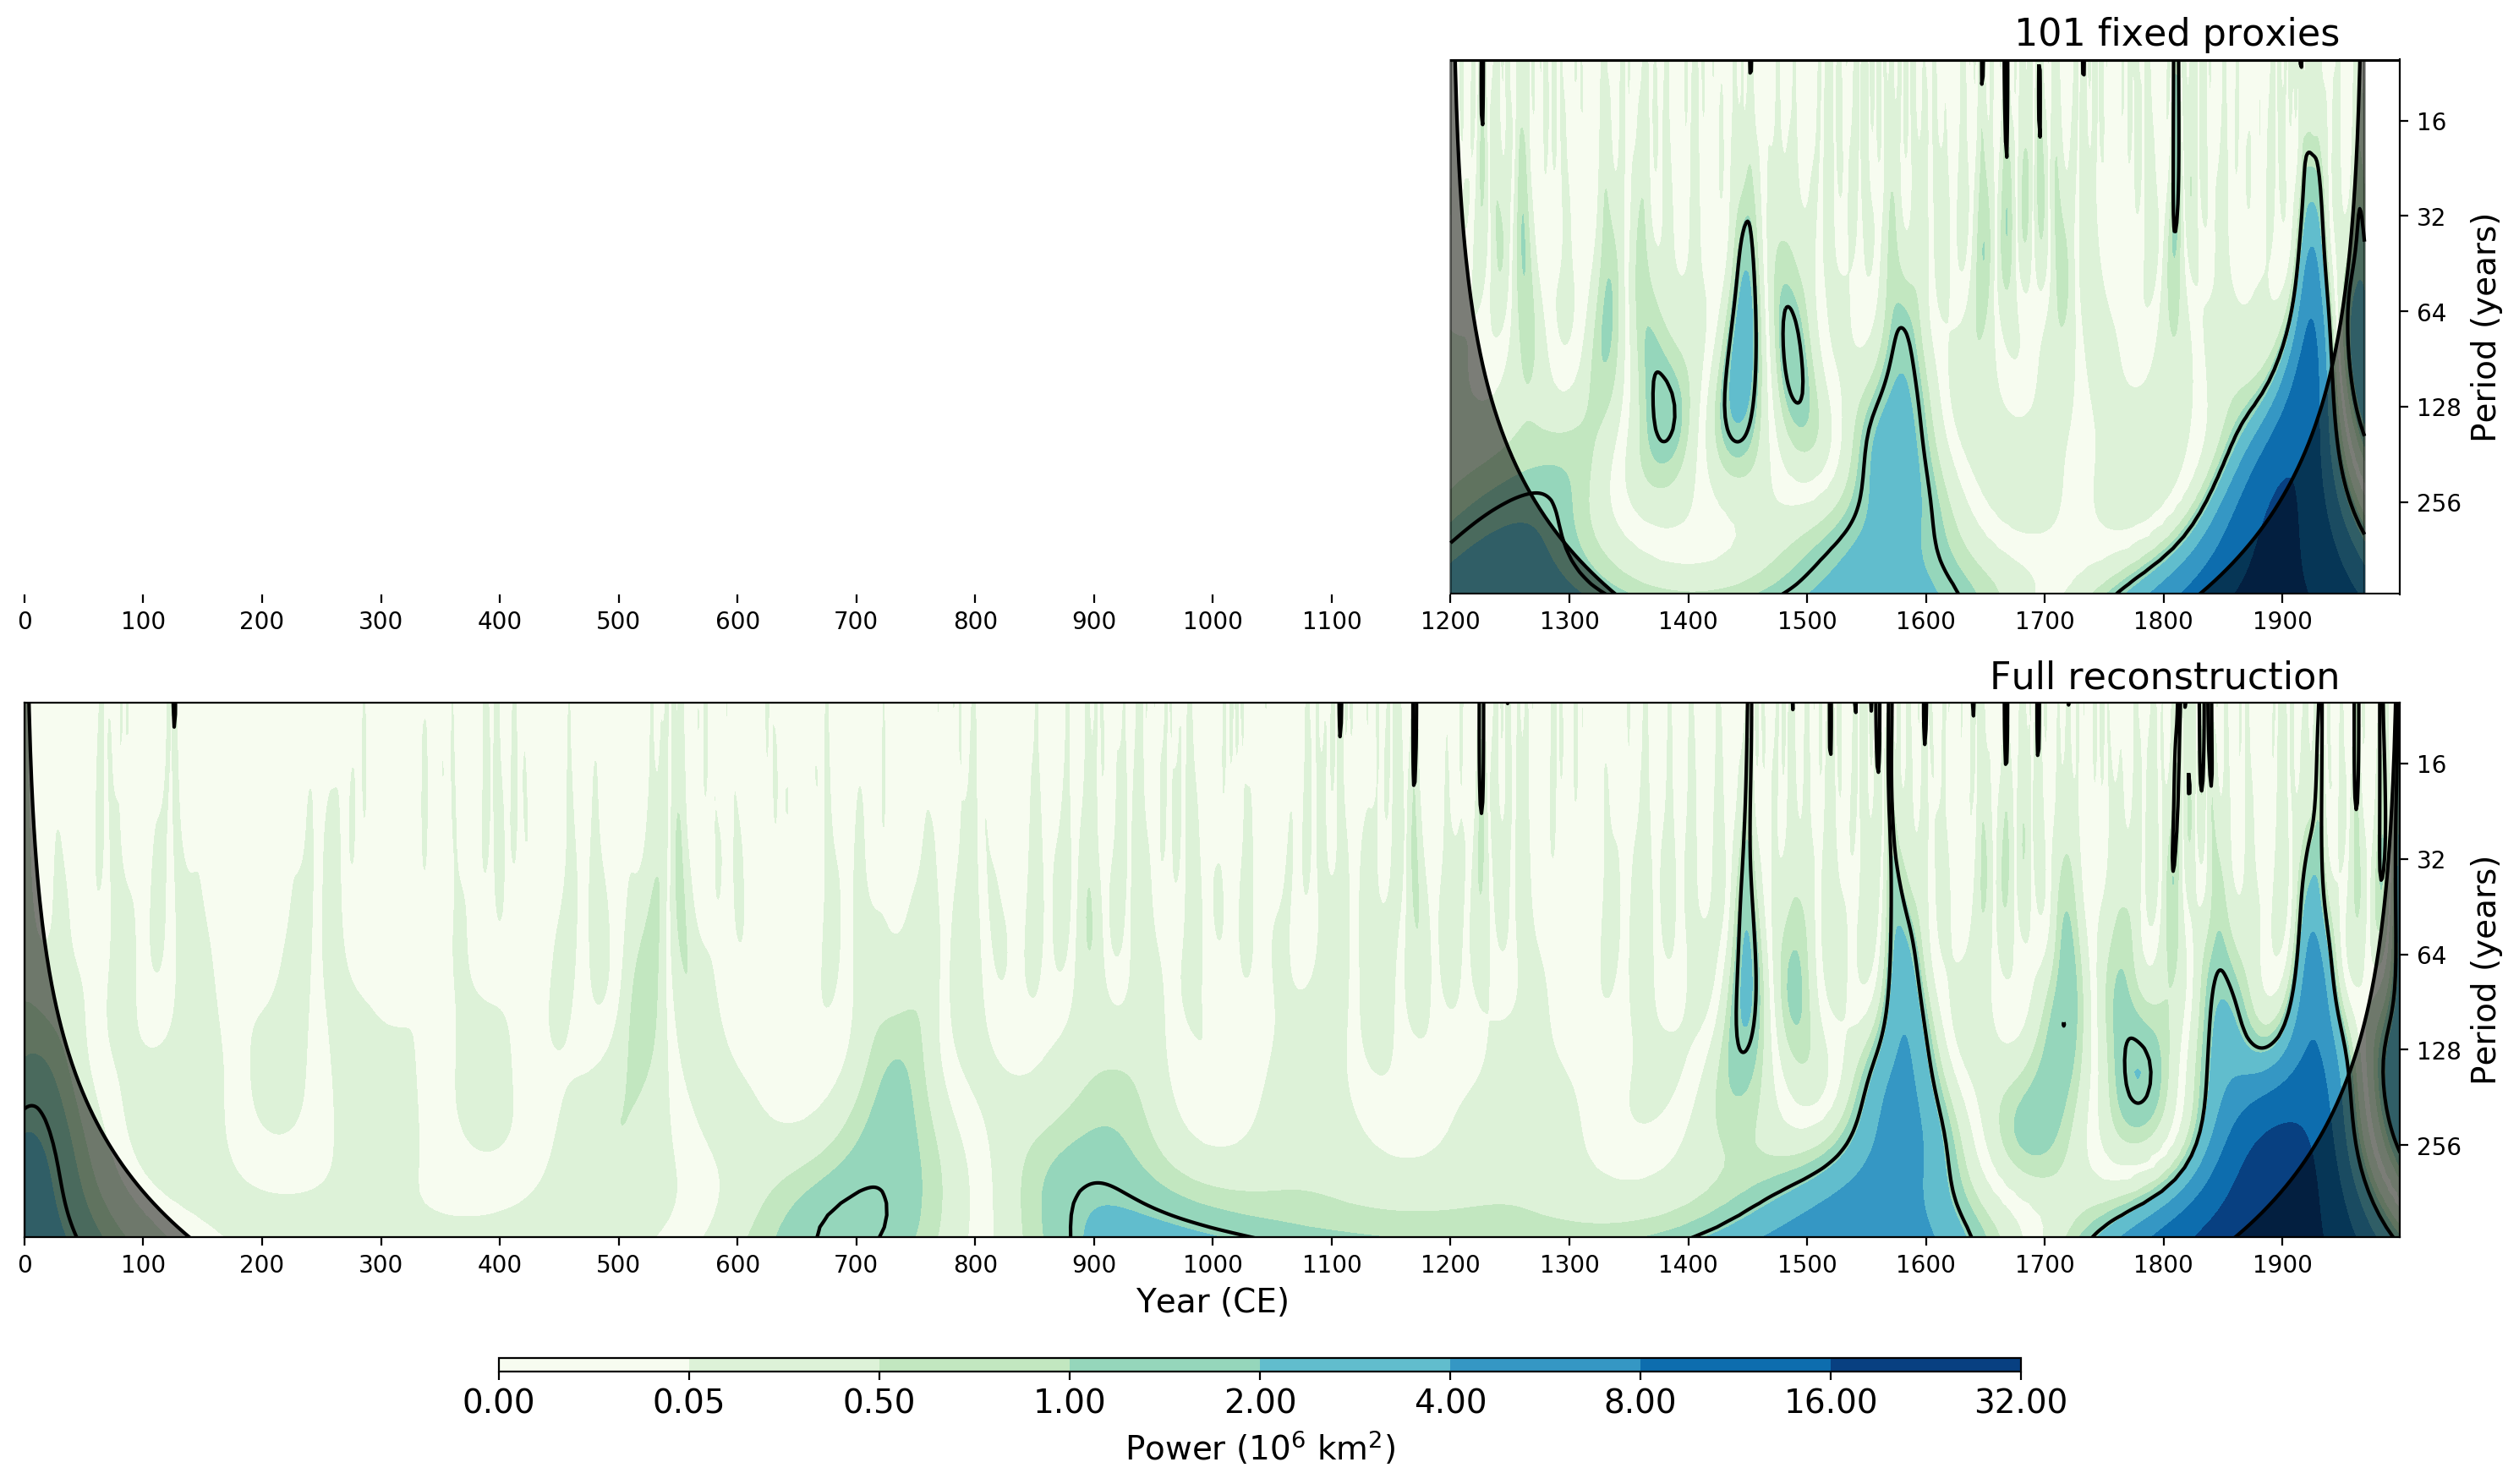

In [341]:
fig, ax = plt.subplots(2,1,figsize=(15, 8), sharex=True)
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32]
title_f400 = '134 fixed proxies     '
title_f770 = '101 fixed proxies     '
title_full = 'Full reconstruction     '

ax[0].set_xticks(np.arange(0,2000,100))
ax[1].set_xticks(np.arange(0,2000,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[0], time_f770, period_f770, power_f770, sig95_f770, coi_f770, title_f770, 
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[1], time_full, period_full, power_full, sig95_full, coi_full, title_full,
              levels=levels, cmap='GnBu')

# ax[1].axhline(20)
# ax[1].axhline(70)

ax[1].set_xlabel('Year (CE)', fontsize=14)

#ax[2].set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].hlines(10.3,1200,2000,color='k')
ax[0].hlines(500,1200,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG1_f770_full_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


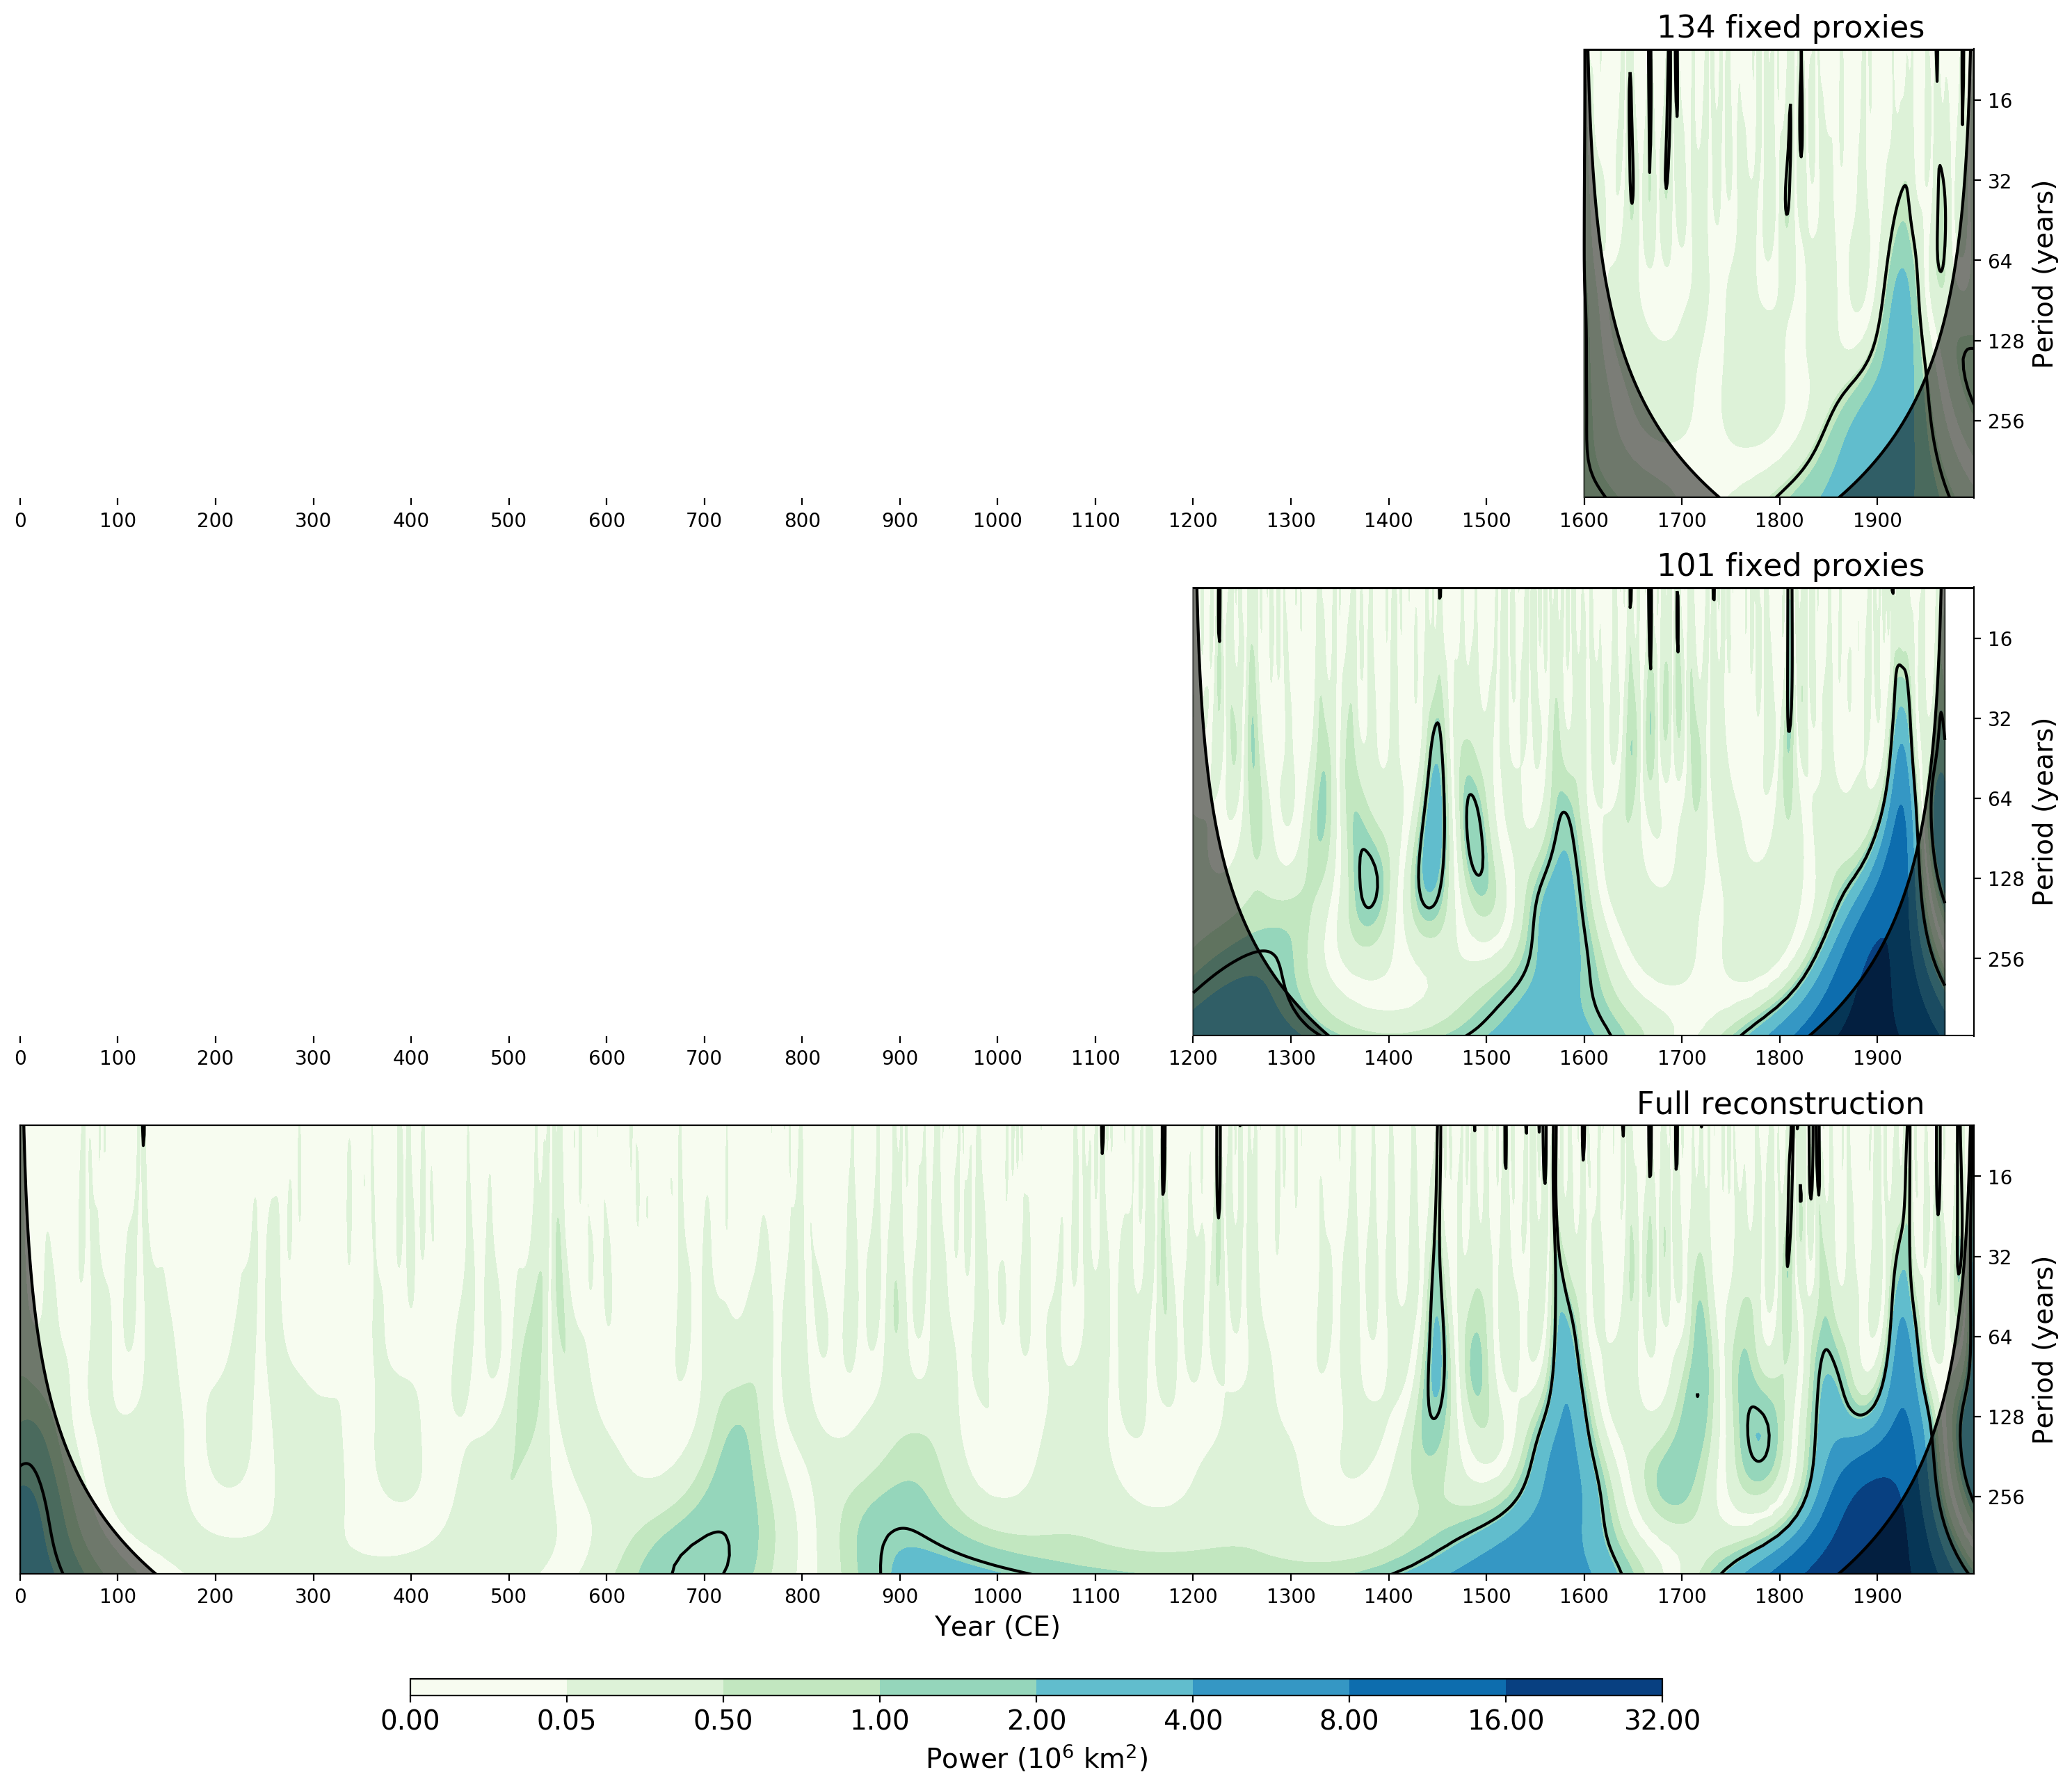

In [138]:
fig, ax = plt.subplots(3,1,figsize=(15, 12), sharex=True)
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32]
title_f400 = '134 fixed proxies     '
title_f770 = '101 fixed proxies     '
title_full = 'Full reconstruction     '

ax[0].set_xticks(np.arange(0,2000,100))
ax[1].set_xticks(np.arange(0,2000,100))
ax[2].set_xticks(np.arange(0,2000,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[0], time_f400, period_f400, power_f400, sig95_f400, coi_f400, title_f400, 
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[1], time_f770, period_f770, power_f770, sig95_f770, coi_f770, title_f770, 
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[2], time_full, period_full, power_full, sig95_full, coi_full, title_full,
              levels=levels, cmap='GnBu')

# ax[1].axhline(20)
# ax[1].axhline(70)

ax[2].set_xlabel('Year (CE)', fontsize=14)

#ax[2].set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].hlines(10.3,1200,2000,color='k')
ax[0].hlines(10.3,1600,2000,color='k')
# ax[1].hlines(8,1200,2000,color='k')
# ax[0].hlines(8,1600,2000,color='k')
ax[1].hlines(500,1200,2000,color='k')
ax[0].hlines(500,1600,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG2_f400_f770_full_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

In [116]:
period_f400_sat_append.min()

10.260398641294913

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


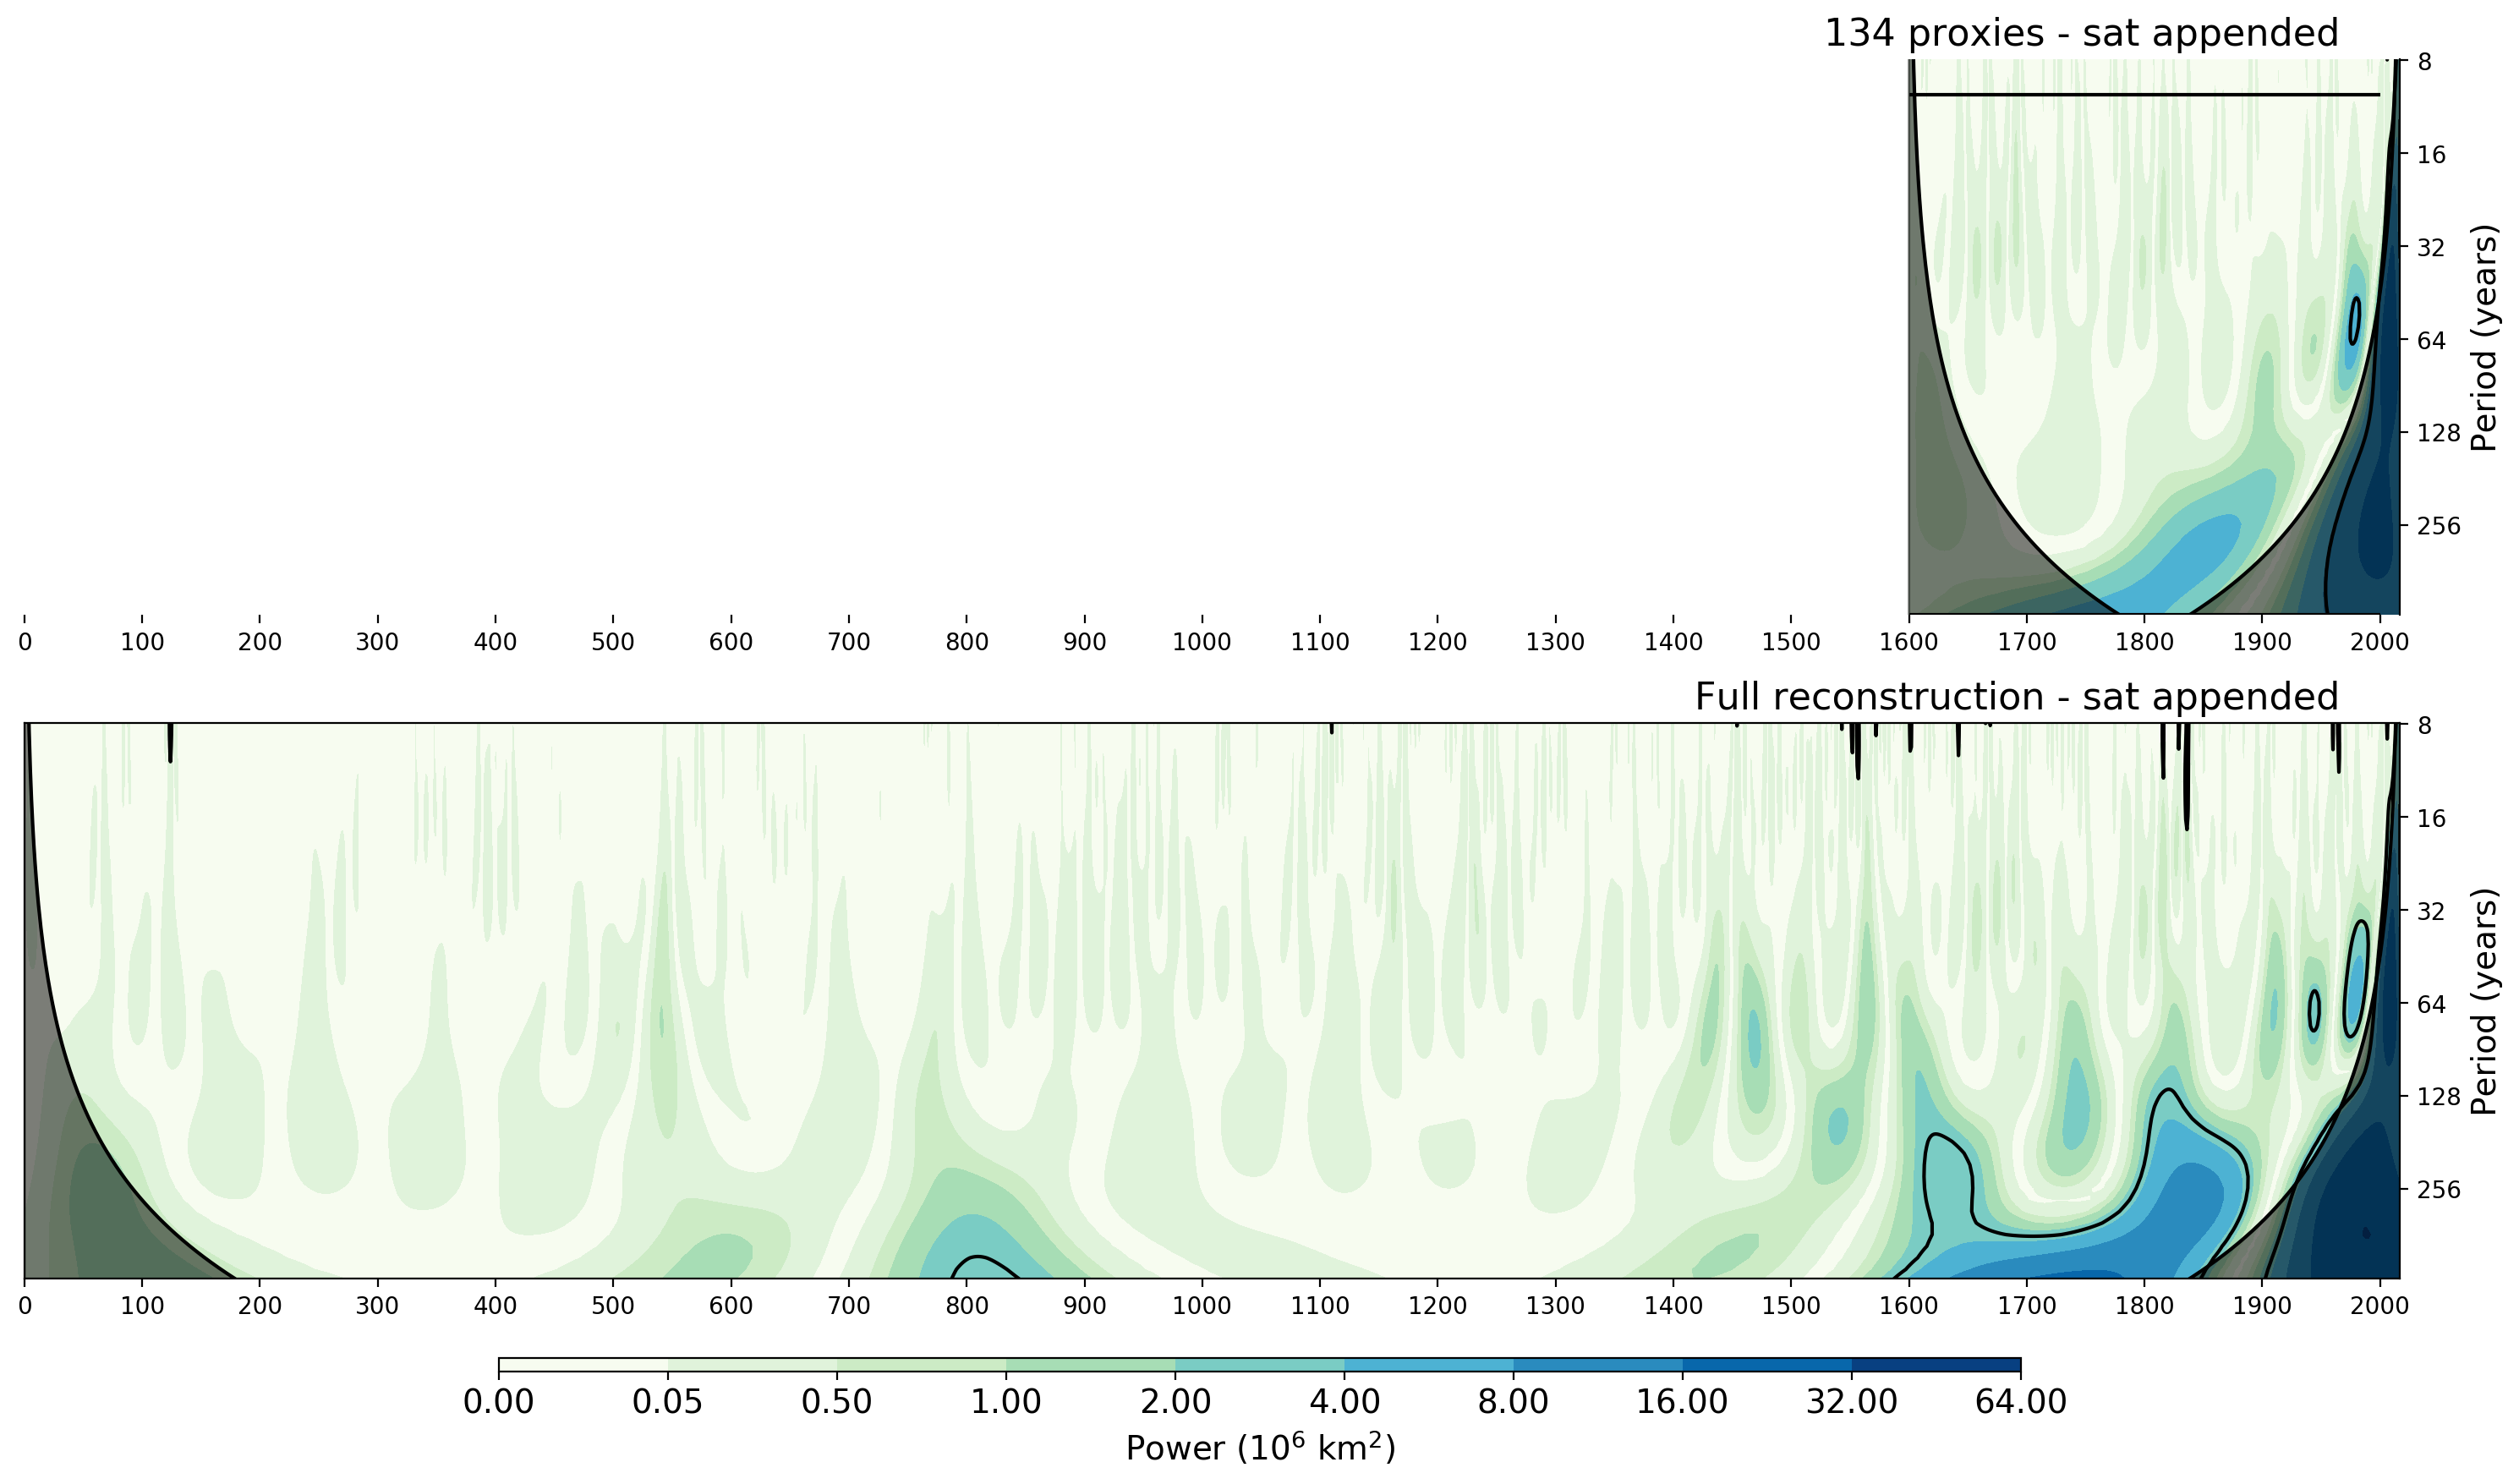

In [127]:
fig, ax = plt.subplots(2,1,figsize=(15, 8), sharex=True)
ax = ax.flatten()
levels = [10-10,0.05,0.5,1,2,4,8,16,32,64]
title_full_sat_append = 'Full reconstruction - sat appended     '
title_f400_sat_append = '134 proxies - sat appended     '

ax[0].set_xticks(np.arange(0,2020,100))
ax[1].set_xticks(np.arange(0,2020,100))

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
#ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

im2 = plot_cwt(fig, ax[0], time_f400_sat_append, period_f400_sat_append, power_f400_sat_append, 
              sig95_f400_sat_append, coi_f400_sat_append, title_f400_sat_append,
              levels=levels, cmap='GnBu')
im = plot_cwt(fig, ax[1], time_full_sat_append, period_full_sat_append, power_full_sat_append, 
              sig95_full_sat_append, coi_full_sat_append, title_full_sat_append,
              levels=levels, cmap='GnBu')

ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

ax[0].hlines(10.3,1600,2000,color='k')
ax[0].hlines(500,1600,2000,color='k')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG1_f400_full_satappended_sharex.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## Wavelet analysis: volcanic forcing 

In [61]:
dt = 1
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array

pad = 1  # pad the time series with zeroes (recommended)
dj =  0.125  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
#lag1 = 0.59  # lag-1 autocorrelation for red noise background
#print("lag1 = ", lag1)
mother = 'DOG'
#mother = 'PAUL'
#mother = 'MORLET'

In [71]:
lag1_volc_sum = calc_lac(volc_colmass_gman_sum[:-1], volc_colmass_gman_sum[1:])
lag1_volc = calc_lac(volc_colmass_gman[:-1], volc_colmass_gman[1:])

lag1_volc_sum, lag1_volc 

(0.50725794, 0.50725806)

In [72]:
[period_volc_sum, power_volc_sum, 
 sig95_volc_sum, coi_volc_sum,
 time_volc_sum] = get_cwt(volc_colmass_gman_sum,volc_time,
                      dt,pad,dj,s0,j1,mother,lag1_volc_sum ,param=1)

[period_volc, power_volc, 
 sig95_volc, coi_volc,
 time_volc] = get_cwt(volc_colmass_gman,volc_time,
                      dt,pad,dj,s0,j1,mother,lag1_volc ,param=1)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


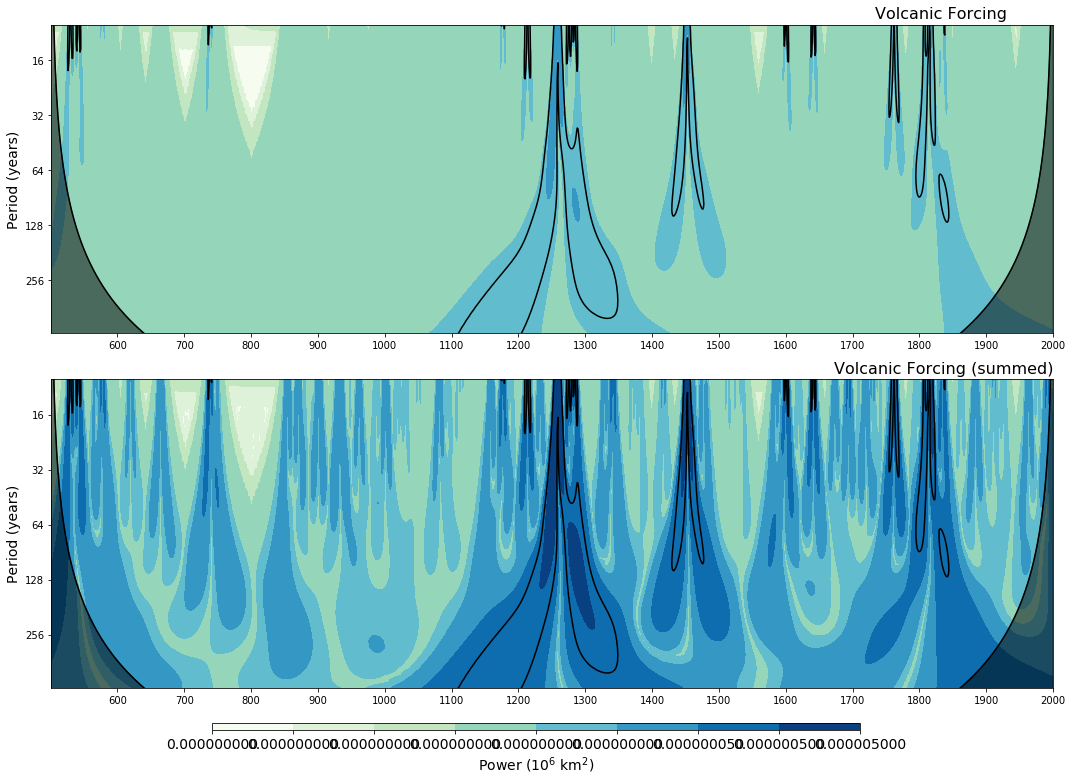

In [78]:
fig, ax = plt.subplots(2,1,figsize=(15, 10))
ax = ax.flatten()
levels = [10-10,5e-40,5e-30,5e-20,5e-10,5e-9,5e-8,5e-7,5e-6]

title_volc_sum = 'Volcanic Forcing (summed)'
title_volc = 'Volcanic Forcing         '

ax[0].set_xticks(np.arange(500,2001,100))
ax[1].set_xticks(np.arange(500,2001,100))
#ax[1].set_xticks(np.arange(0,2020,100))

# ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
# ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

im = plot_cwt(fig, ax[1], volc_time, period_volc_sum, power_volc_sum, 
              sig95_volc_sum, coi_volc_sum, title_volc_sum,
              levels=levels, cmap='GnBu')
im2 = plot_cwt(fig, ax[0], volc_time, period_volc, power_volc, 
              sig95_volc, coi_volc, title_volc,
              levels=levels, cmap='GnBu')

# set up the size and location of the colorbar
position=fig.add_axes([0.2,-0.02,0.6,0.01])
cb = plt.colorbar(im, cax=position, orientation='horizontal') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
cb.set_label("Power (10$^6$ km$^2$)", fontsize=14)

plt.xticks(fontsize=14)
plt.subplots_adjust(right=0.7, top=0.9)
plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'cw_analysis_DOG2_f400_f770_full_sharex.png'
#plt.savefig(savedir+savename)

In [67]:
power_volc.min(), power_volc.max()

(2.4010737103580624e-42, 4.420562988271002e-06)

## 

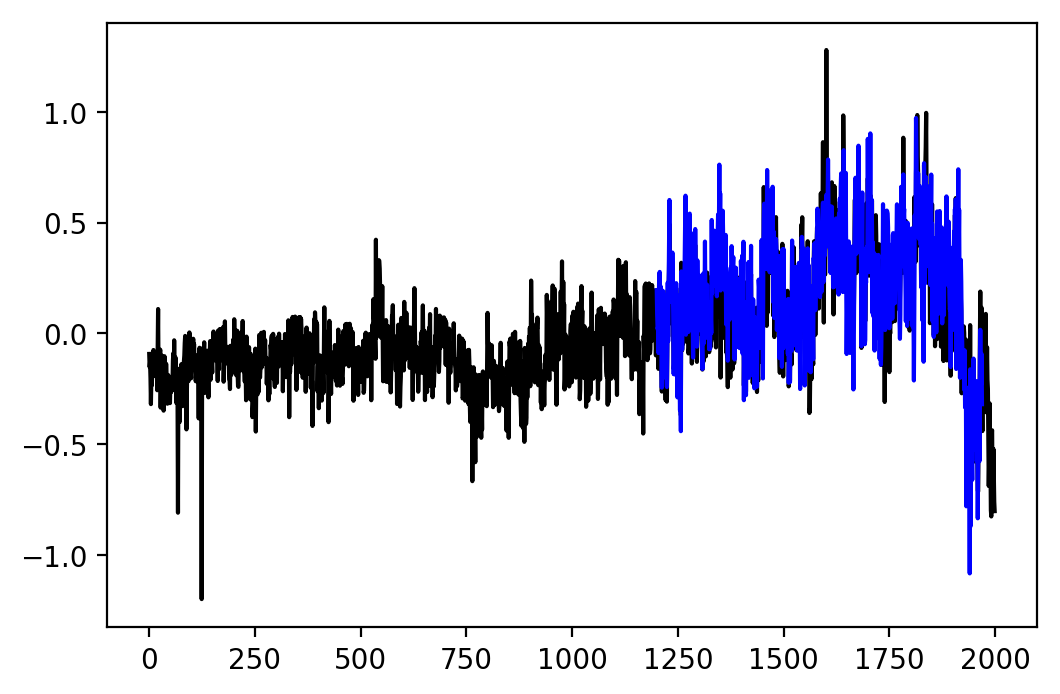

In [208]:
plt.plot(recon_years_full, sie_ensmn_anom_allit_full, color='k')
plt.plot(recon_years_f770, sie_ensmn_anom_allit_f770, color='b')

In [ ]:
# READ THE DATA
# sst = np.loadtxt('sst_nino3.dat')  # input SST time series
# sst = sst - np.mean(sst)

sst = sie_ensmn_anom_allit_f400
variance = np.std(sst, ddof=1) ** 2
print("variance = ", variance)

if 0:
    variance = 1.0
    sst = sst / np.std(sst, ddof=1)
n = len(data)
dt = 1
time = np.array(recon_years_f400)
#time = np.arange(len(sst)) * dt + 1871.0  # construct time array
xlim = ([1600,1999])  # plotting range
pad = 1  # pad the time series with zeroes (recommended)
dj =  0.125  # this will do 4 sub-octaves per octave
s0 = 2 * dt  # this says start at a scale of 6 months
j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each
lag1 = 0.59  # lag-1 autocorrelation for red noise background
print("lag1 = ", lag1)
mother = 'DOG'

In [299]:
# Wavelet transform:
wave, period, scale, coi = wavelet(sst, dt, pad, dj, s0, j1, mother, param=2)
power = (np.abs(wave)) ** 2  # compute wavelet power spectrum
global_ws = (np.sum(power, axis=1) / n)  # time-average over all times

In [ ]:
# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

In [ ]:
# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

In [ ]:
# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

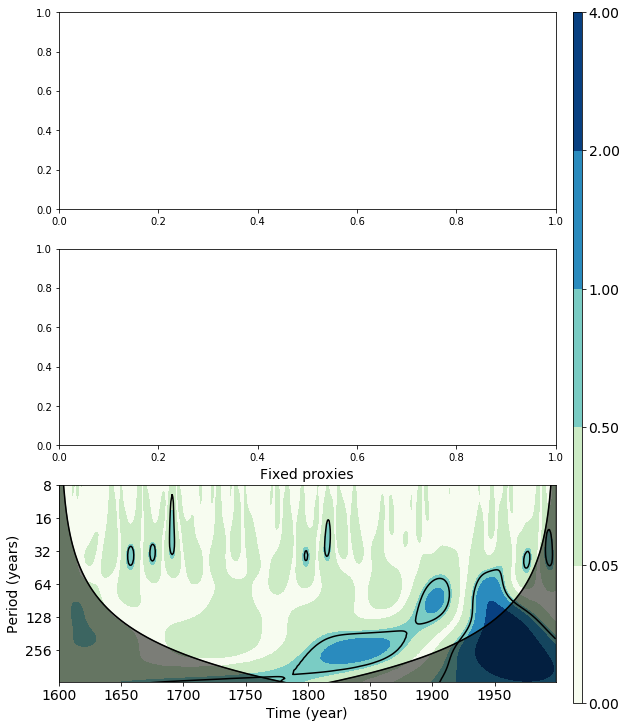

In [358]:
fig, ax = plt.subplots(3,1,figsize=(12, 12))
ax = ax.flatten()
levels = [0,0.05,0.5,1,2,4]
title = 'Fixed proxies'

plot_cwt(fig, ax[2], time, period, power, sig95, coi, title, levels=levels, cmap='GnBu')

# set up the size and location of the colorbar
position=fig.add_axes([0.72,0.1,0.01,0.8])
cb = plt.colorbar(im, cax=position, orientation='vertical') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)
plt.subplots_adjust(right=0.7, top=0.9)

In [ ]:
#--- Plot time series
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(recon_years_full, np.mean(sie_ens_allit_2d_full,axis=0), color='k')
#plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

# plt.text(time[-1] + 35, 0.5,'Wavelet Analysis\nC. Torrence & G.P. Compo\n' +
#     'http://paos.colorado.edu/\nresearch/wavelets/',
#     horizontalalignment='center', verticalalignment='center')

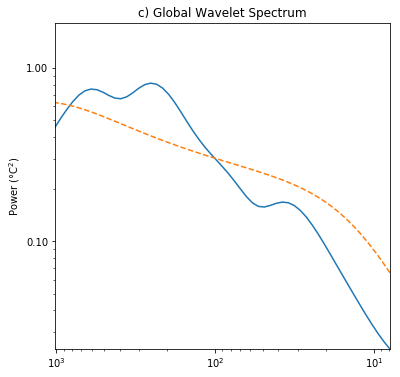

In [354]:
#--- Plot global wavelet spectrum
#plt4 = plt.subplot(gs[1, -1])
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(period,global_ws, )
plt.plot(period, global_signif, '--')

plt.ylabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')

plt.ylim([0, 1.25 * np.max(global_ws)])
# format y-scale

plt.ylim([np.min(global_ws), np.max(global_ws)+1])
plt.xlim([np.min(period), np.max(period)])

ax.set_xscale('log')
ax.set_yscale('log')

ax_x = plt.gca().yaxis
ax_x.set_major_formatter(ticker.ScalarFormatter())
#ax_x.set_xscale('log')

#ax.ticklabel_format(axis='x', style='plain')
ax.invert_xaxis()

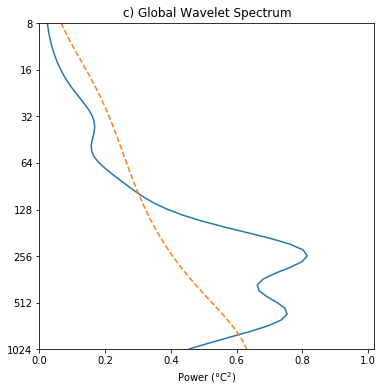

In [313]:
#--- Plot global wavelet spectrum
#plt4 = plt.subplot(gs[1, -1])
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
ax.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax_y = plt.gca().yaxis
ax_y.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain')
ax.invert_yaxis()

In [247]:
base2

9.0

In [249]:
Y = sst
J1=j1
n1 = len(Y)
mother = 'MORLET'
param=-1

if s0 == -1:
    s0 = 2 * dt
if dj == -1:
    dj = 1. / 4.
if J1 == -1:
    J1 = np.fix((np.log(n1 * dt / s0) / np.log(2)) / dj)
if mother == -1:
    mother = 'MORLET'

#....construct time series to analyze, pad if necessary
#x = Y - np.mean(Y)
if pad == 1:
    base2 = np.fix(np.log(n1) / np.log(2) + 0.4999)  # power of 2 nearest to N
    x = np.concatenate((x, np.zeros((2 ** (base2 + 1) - n1).astype(np.int64))))

n = len(x)

#....construct wavenumber array used in transform [Eqn(5)]
kplus = np.arange(1, np.fix(n / 2 + 1))
kplus = (kplus * 2 * np.pi / (n * dt))
kminus = (-(kplus[0:-1])[::-1])
k = np.concatenate(([0.], kplus, kminus))

#....compute FFT of the (padded) time series
f = np.fft.fft(x)  # [Eqn(3)]

#....construct SCALE array & empty PERIOD & WAVE arrays
j = np.arange(0, J1+1)
scale = s0 * 2. ** (j * dj)
wave = np.zeros(shape=(int(J1 + 1), n), dtype=complex)  # define the wavelet array
daught = np.zeros(shape=(int(J1 + 1),n))

for a1 in range(0, int(J1+1)):
    daughter, fourier_factor, coi, dofmin = wave_bases(mother, k, scale[a1], param)
    daught[a1,:] = daughter
    wave[a1, :] = np.fft.ifft(f * daughter)  # wavelet transform[Eqn(4)]
    
period = fourier_factor * scale  # [Table(1)]
coi = coi * dt * np.concatenate((np.insert(np.arange(int((n1 + 1) / 2 - 1)), [0], [1E-5]),
                                 np.insert(np.flipud(np.arange(0, n1 / 2 - 1)), [-1], [1E-5])))  # COI [Sec.3g]
wave1 = wave[:, :n1]  # get rid of padding before returning

In [246]:
k

array([ 0.        ,  0.00381261,  0.00762522, ..., -0.01143784,
       -0.00762522, -0.00381261])

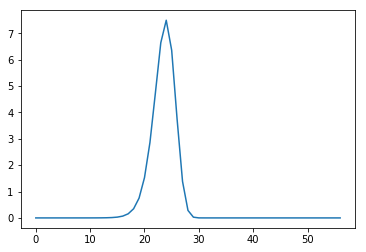

In [248]:
plt.plot(daught[:,100])
#plt.xlim(0,1000)

In [250]:
wave1.shape, wave.shape

((57, 400), (57, 2272))

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


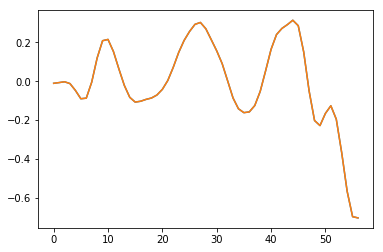

In [251]:
plt.plot(wave[:,100])
plt.plot(wave1[:,100])

In [197]:
n = len(k)
kplus = np.array(k > 0., dtype=float)

if mother == 'MORLET':  # -----------------------------------  Morlet

    if param == -1:
        param = 6.

    k0 = np.copy(param)
    expnt = -(scale * k - k0) ** 2 / 2. * kplus
    norm = np.sqrt(scale * k[1]) * (np.pi ** (-0.25)) * \
            np.sqrt(n)  # total energy=N   [Eqn(7)]
    daughter = norm * np.exp(expnt)
    daughter = daughter * kplus  # Heaviside step function
    fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2)
                                        )  # Scale-->Fourier [Sec.3h]
    coi = fourier_factor / np.sqrt(2)  # Cone-of-influence [Sec.3g]
    dofmin = 2  # Degrees of freedom

ValueError: operands could not be broadcast together with shapes (57,) (1024,) 

In [193]:
for a1 in range(0, int(J1+1)):
        daughter, fourier_factor, coi, dofmin = wave_bases(mother, k, scale[a1], param)
        wave[a1, :] = np.fft.ifft(f * daughter)  # wavelet transform[Eqn(4)]

(57, 770)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


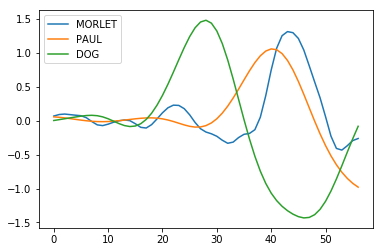

In [254]:
time = 700
plt.plot(wave_morlet[:,time], label='MORLET')
plt.plot(wave_paul[:,time], label='PAUL')
plt.plot(wave_dog[:,time], label='DOG')
plt.legend()

In [300]:
# Significance levels:
signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,lag1=lag1, mother=mother)
sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand signif --> (J+1)x(N) array
sig95 = power / sig95  # where ratio > 1, power is significant

In [301]:
# Global wavelet spectrum & significance levels:
dof = n - scale  # the -scale corrects for padding at edges
global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
    lag1=lag1, dof=dof, mother=mother)

In [302]:
# Scale-average between El Nino periods of 2--8 years
avg = np.logical_and(scale >= 2, scale < 8)
Cdelta = 0.776  # this is for the MORLET wavelet
scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])  # expand scale --> (J+1)x(N) array
scale_avg = power / scale_avg  # [Eqn(24)]
scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
    lag1=lag1, dof=([2, 7.9]), mother=mother)

Text(2034,0.5,'Wavelet Analysis\nC. Torrence & G.P. Compo\nhttp://paos.colorado.edu/\nresearch/wavelets/')

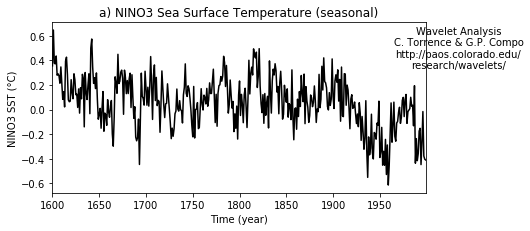

In [303]:
#--- Plot time series
fig = plt.figure(figsize=(9, 10))
gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95, wspace=0, hspace=0)
plt.subplot(gs[0, 0:3])
plt.plot(time, sst, color='k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('NINO3 SST (\u00B0C)')
plt.title('a) NINO3 Sea Surface Temperature (seasonal)')

plt.text(time[-1] + 35, 0.5,'Wavelet Analysis\nC. Torrence & G.P. Compo\n' +
    'http://paos.colorado.edu/\nresearch/wavelets/',
    horizontalalignment='center', verticalalignment='center')

In [304]:
time.shape

(400,)

In [305]:
#cmap = plt.cm.get_cmap('pink_r')
cmap = plt.cm.get_cmap('GnBu')

c1 = cmap(0)
c2 = cmap(0.25)
c3 = cmap(0.5)
c4 = cmap(0.75)
c5 = cmap(1.0)

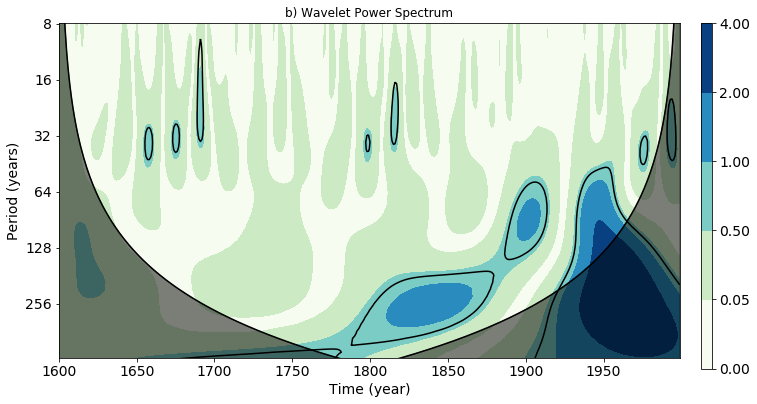

In [310]:
#--- Contour plot wavelet power spectrum
#plt3 = plt.subplot(3, 1, 2)
#plt3 = plt.subplot(gs[1, 0:3])
fig, ax = plt.subplots(figsize=(15,6))

#levels = [0, 0.5, 1, 2, 4, 999]
levels = [0,0.05,0.5,1,2,4]

CS = plt.contourf(time, period, power, len(levels))  #*** or use 'contour'
#im = plt.contourf(CS, levels=levels, colors=['white','bisque','orange','orangered','darkred'])
im = plt.contourf(CS, levels=levels, colors=[c1,c2,c3,c4,c5])


plt.xlabel('Time (year)', fontsize=14)
plt.ylabel('Period (years)', fontsize=14)
plt.title('b) Wavelet Power Spectrum')
plt.xlim(xlim[:])

# 95# significance contour, levels at -99 (fake) and 1 (95# signif)
plt.contour(time, period, sig95, [-99, 1], colors='k')

# cone-of-influence, anything "below" is dubious
plt.plot(time, coi, 'k')
plt.fill_between(time,coi,y2=period.max(),color='k', alpha=0.5)

# format y-scale
ax.set_yscale('log', basey=2, subsy=None) #
ax_x = plt.gca().yaxis
ax_x.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(axis='y', style='plain') #

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim([np.min(period), 500])

# set up the size and location of the colorbar
#position=fig.add_axes([0.5,0.36,0.2,0.01]) 
position=fig.add_axes([0.72,0.1,0.01,0.8])
cb = plt.colorbar(im, cax=position, orientation='vertical') #, fraction=0.05, pad=0.5)
cb.ax.tick_params(labelsize=14)

ax.invert_yaxis() #

plt.subplots_adjust(right=0.7, top=0.9)

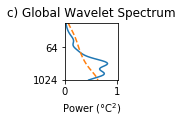

In [138]:
#--- Plot global wavelet spectrum
plt4 = plt.subplot(gs[1, -1])
plt.plot(global_ws, period)
plt.plot(global_signif, period, '--')
plt.xlabel('Power (\u00B0C$^2$)')
plt.title('c) Global Wavelet Spectrum')
plt.xlim([0, 1.25 * np.max(global_ws)])
# format y-scale
plt4.set_yscale('log', basey=2, subsy=None)
plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt4.ticklabel_format(axis='y', style='plain')
plt4.invert_yaxis()


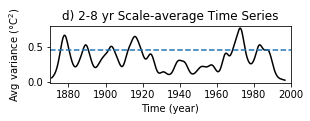

In [11]:
# --- Plot 2--8 yr scale-average time series
plt.subplot(gs[2, 0:3])
plt.plot(time, scale_avg, 'k')
plt.xlim(xlim[:])
plt.xlabel('Time (year)')
plt.ylabel('Avg variance (\u00B0C$^2$)')
plt.title('d) 2-8 yr Scale-average Time Series')
plt.plot(xlim, scaleavg_signif + [0, 0], '--')